In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyneb as pn

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
from scipy.interpolate import Akima1DInterpolator
from scipy import optimize as opt
import sys
import emcee
import numpy as np
from scipy.optimize import curve_fit
from astropy.table import Table

import numpy as np
from astropy.io import fits
import time
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy import signal
import matplotlib.pyplot as plt
import warnings
import pandas as pd

In [ ]:
RUBIES_and_CEERS_table = Table.read('MASTER_RUBIES_AND_CEERS_TABLE.fits')
mask = RUBIES_and_CEERS_table['redshift']>6
redshift = RUBIES_and_CEERS_table['redshift'][mask]
flux = RUBIES_and_CEERS_table['flux'][mask]
source_name = RUBIES_and_CEERS_table['filename'][mask]
flux_error = RUBIES_and_CEERS_table['flux_error'][mask]
rest_frame = RUBIES_and_CEERS_table['rest_frame_wavelength'][mask]
flags = RUBIES_and_CEERS_table['flags']

In [ ]:
m_to_ang = 1e+10
speed_of_light = (3*10**8) *m_to_ang
um_to_ang = 10000

h_beta = 4861.333
h_alpha = 6562.819
h_gamma = 4340.1

# OIII4960 = 4958.911
# OIII5007 = 5006.843
# OIII4363 = 4363.210
# h_beta = 4861.333
# h_alpha = 6562.819
# SII6716 = 6716.440
# SII6731 = 6730.810
# OII3726= 3726.032
# OII3729= 3728.815

#https://physics.stackexchange.com/questions/725928/converting-between-f-nu-and-f-lambda-spectral-density

def wavelength_exists(array, wavelength):
    #array = eq.cleaned
    #wavelength = halpha or hbeta
    idx = np.where((array > wavelength - 10) & (array < wavelength + 10))
    if len(flux_cleaned[idx]) == 0:
        return False
    else:
        return True

In [ ]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Line model including continuum
def line(x, b):
    return np.ones(len(x)) * b

def line_model(x, A, mu, sigma, b):
    return gaussian(x, A, mu, sigma) + line(x, b)

def log_likelihood(theta, x, y, yerr):
    model = line_model(x, *theta)
    lnL = -0.5 * np.sum((y - model)**2 / yerr**2)
    return lnL

def log_prior(theta, wave_center, Amp_max):
    A, mu, sigma, b = theta
    left_mu = wave_center - 5
    right_mu = wave_center + 5
    min_A = 0
    max_A = Amp_max * 2
    sigma_window_left = 0.0001
    sigma_window_right = 50
    if (0 < A < max_A) & (left_mu <= mu <= right_mu) & (sigma_window_left <= sigma < sigma_window_right) & (b > 0):
        return 0.0
    else:
        return -np.inf

def log_probability(theta, x, y, yerr, wave_center, Amp_max):
    lp = log_prior(theta, wave_center, Amp_max)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# Function to fit the Hα and Hβ lines
def fitting_line(wave, flux, flux_err, line_center, window_wavelength, diagnose=False):
    min_window = line_center - window_wavelength
    max_window = line_center + window_wavelength
    indx = (wave >= min_window) & (wave <= max_window)
    
    spec_window = flux[indx]
    wave_window = wave[indx]
    err_spec_window = flux_err[indx]
    
    # Initial guess for the curve fit
    guess_A = np.abs(np.max(spec_window))
    guess_mu = line_center
    guess_sigma = 1.0
    guess_b = np.abs(np.median(spec_window))
    
    low_bounds = [0, min_window, 0, -guess_b]
    high_bounds = [2 * guess_A, max_window, 100, 2 * guess_b]
    popt, _ = curve_fit(line_model, wave_window, spec_window, p0=[guess_A, guess_mu, guess_sigma, guess_b],
                        bounds=(low_bounds, high_bounds))
    if diagnose == True: 
        plotting_code = line_model(wave_window,popt[0],popt[1],popt[2],popt[3])
#         plt.figure()
#         plt.plot(wave_window,plotting_code,c='cadetblue',label='model')
#         plt.plot(wave_window,spec_window,c='purple',label='data')
#         plt.axvline(min_window)
#         plt.axvline(max_window)

#         plt.legend()
#         plt.show()
    fluxes_emcee = popt[0] * popt[2] * np.sqrt(2 * np.pi)
    
   # return fluxes_emcee
    return popt



def emcee_fit(wave, flux, flux_err, line_center, window_wavelength, 
                 diagnose = False,save=True, filename = 'Emcee_Chains_Galaxy.txt'):
    
    result = fitting_line(wave, flux, flux_err, line_center, window_wavelength, diagnose=True)
    
    #getting the results from the initial fit to then pass into emcee
    guess_A = result[0]
    guess_mu = result[1]
    guess_sigma = result[2]
    guess_b = result[3]
    
    
    #making walkers so that we can use emcee to explore the parameter space
    #centered on the best results from minimization
    amp_jump = np.random.normal(loc = guess_A,            #centered on best A from minimization
                                scale = guess_A/10,       #can wander 1/10 of the value of A
                                size = 32).reshape(-1, 1) 
    
    wavelength_jump = np.random.normal(loc = guess_mu,    #centered on best mu from minimization
                                       scale = .005,      #can wander +/- 0.005 microns 
                                       size = 32).reshape(-1, 1)
    
    sigma_jump = np.random.normal(loc = guess_sigma, scale = .002, size = 32).reshape(-1, 1)

    
    powerb = np.log10(np.abs(guess_b))
    
    b_jump = np.random.normal(loc = guess_b, scale = 1*10**powerb, size = 32).reshape(-1, 1)

    
    #################
    # Diagnostic plotting to see if the parameters were jumping to large values
    # The should be concentrated near their best fit results values
    #################
    if diagnose == True:
        print('Checking the Walker Jumps')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        ax[0, 0].hist(amp_jump)
        ax[0, 0].set_xlabel('Amplitude')
        
        ax[0, 1].hist(wavelength_jump)
        ax[0, 1].set_xlabel(r'$\mu$')
        
        ax[1, 0].hist(sigma_jump)
        ax[1, 0].set_xlabel(r'$\sigma$')
        
        ax[1, 1].hist(b_jump)
        ax[1, 1].set_xlabel('b')
        
        plt.show()
    

    #stacking along the columns
    starting_walkers = np.hstack((amp_jump,
                                  wavelength_jump, 
                                  sigma_jump, 
                                  #m_jump, 
                                  b_jump))

    #initializing window for emcee around the best result mu
    emcee_window = window_wavelength #in units of microns
    emcee_indx = np.where((wave >= (line_center - emcee_window)) & 
                          (wave <= (line_center + emcee_window)))[0]

    #emcee subsections
    emcee_spec = flux[emcee_indx]
    emcee_wave = wave[emcee_indx]
    emcee_err = flux_err[emcee_indx]
    
    
    ###########
    #NOTE:
    #need to change output name everytime you run otherwise it will overwrite
    ###########
    
    #saves the input emcee spectra
    emcee_spec_matrix = np.c_[emcee_wave, emcee_spec, emcee_err]
    #np.savetxt(f'Emcee_Spectra.txt', emcee_spec_matrix)

    #initializing walker positions
    pos = starting_walkers
    nwalkers, ndim = pos.shape

    #initializing sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(emcee_wave, emcee_spec, emcee_err, guess_mu, guess_A), 
                                    moves = [(emcee.moves.DEMove(), 0.5),
                                             (emcee.moves.DESnookerMove(), 0.5)])

    #running it
    sampler.run_mcmc(pos, 3000, progress=False)

    #getting values back
    #samples = sampler.get_chain()
    flat_samples = sampler.get_chain(flat=True)
    LnL_chain = sampler.flatlnprobability
    burn_in = 1000 
    
    emcee_df = pd.DataFrame()
    emcee_df['A'] = flat_samples[burn_in:, 0]
    emcee_df['mu'] = (flat_samples[burn_in:, 1] ) 
    emcee_df['sigma'] = flat_samples[burn_in:, 2]
    emcee_df['b'] = flat_samples[burn_in:, 3]
    emcee_df['LnL'] = LnL_chain[burn_in:]
    
    emcee_df = emcee_df[np.isfinite(emcee_df.LnL.values)]
    conversion_factor = speed_of_light / ((emcee_df['mu']* um_to_ang)**2)

    fluxes_emcee = (emcee_df['A']*conversion_factor) * (emcee_df['sigma']*um_to_ang) * np.sqrt(2 * np.pi)
    emcee_df['Fluxes'] = fluxes_emcee 
    
    if diagnose == True:
        
        print('Checking Prameter Posterior Distributions')
        fig, ax = plt.subplots(nrows = 2, ncols = 2, constrained_layout = True)
        
        emcee_df.A.hist(ax = ax[0, 0])
        emcee_df.mu.hist(ax = ax[0, 1])
        emcee_df.sigma.hist(ax = ax[1, 0])
        #emcee_df.m.hist(ax = ax[1, 0])
        emcee_df.b.hist(ax = ax[1, 1])
        
        plt.show()
    
    if diagnose == True:
        xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        
        plt.figure()
        plt.title('Input Emcee Spectra and Emcee Fit')
        plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(xarr, line_model(xarr, *emcee_df.quantile(q = 0.5).values[:-2]), label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
    
    if diagnose == True:
        plt.figure()
        #xarr = np.linspace(emcee_wave[0], emcee_wave[-1], 100)
        plt.title('Residual (Data - Model)')
        #plt.plot(emcee_wave, emcee_spec, color = 'black', alpha = 0.5, label = 'Data')
        #plt.scatter(emcee_wave, emcee_spec, color = 'black')
        plt.plot(emcee_wave, line_model(emcee_wave, *emcee_df.quantile(q = 0.5).values[:-2])-emcee_spec, label = 'Model')
        plt.xlabel(r'Wavelength [$\mu$m]')
        plt.ylabel('Residual Flux')
        plt.legend()
        print(np.abs( np.mean(line_model(emcee_wave, *emcee_df.quantile(q = 0.5).values[:-2])-emcee_spec)))
        plt.show()
    ###########
    #NOTE:
    #need to also give the filename argument otherwise it will overwrite the default file
    ###########
    if save == True:
        emcee_df.to_csv(filename, sep = ' ')
        
    else:
        return np.median(emcee_df['Fluxes'])

## RUBIES DUST CORRECTION

the point of the code below is to dust correct z<6 with the Hα/Hβ balmer decrement and z>6 with Hβ/Hγ

calzetti+2001: https://iopscience.iop.org/article/10.1086/324269/pdf

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9716957548811508
-0.06704136881893903
[4.76342592 4.76141224 4.75940318 ... 1.27606746 1.27548637 1.27490569]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8056142634253155
-0.5046927590817601
[5.11015146 5.10756322 5.10498192 ... 1.49014763 1.48950259 1.48885801]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0349573269042254
0.08022819055429001
[4.64739419 4.64561813 4.64384566 ... 1.24898942 1.24842693 1.24786483]


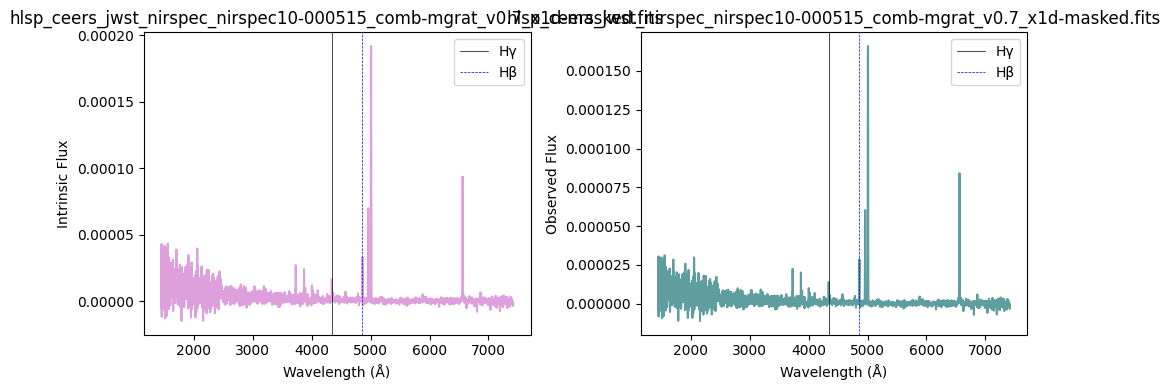

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9393587778324901
-0.14606721511671644
[0.         0.         0.         ... 1.70070609 1.70004275 1.69937976]


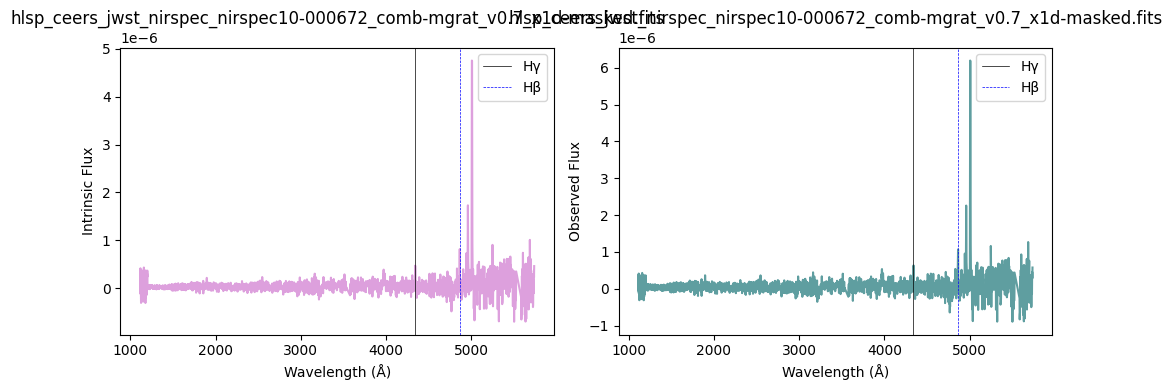

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0198681275763315
0.04593558944077175
[5.02326671 5.02077657 5.01829309 ... 1.39501204 1.39439917 1.39378672]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2559497842667133
0.5321090089550301
[5.00341266 5.00094676 4.99848743 ... 1.37935241 1.37874008 1.37812818]


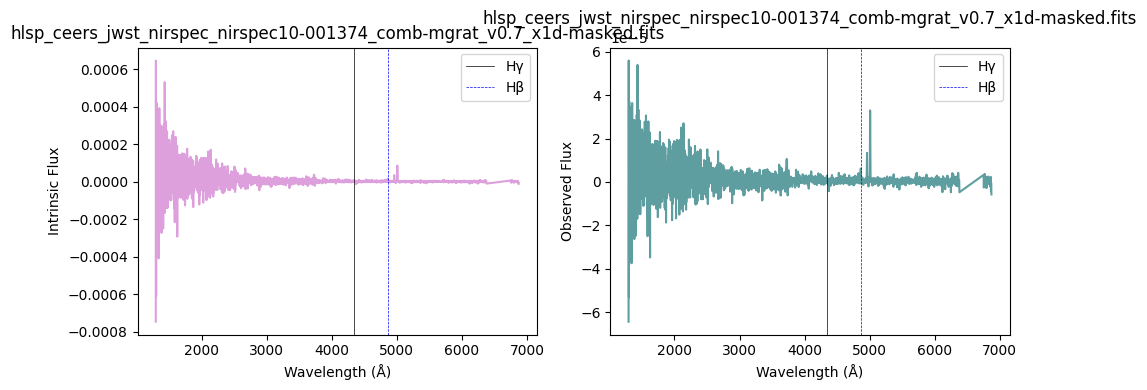

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.5007007889412316
0.9478178002905457
[4.78069486 4.77865178 4.77661346 ... 1.27117791 1.27060663 1.27003576]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7628271633118877
-0.6321174767347841
[5.32711917 5.32395282 5.32079584 ... 1.52126886 1.52060629 1.51994418]


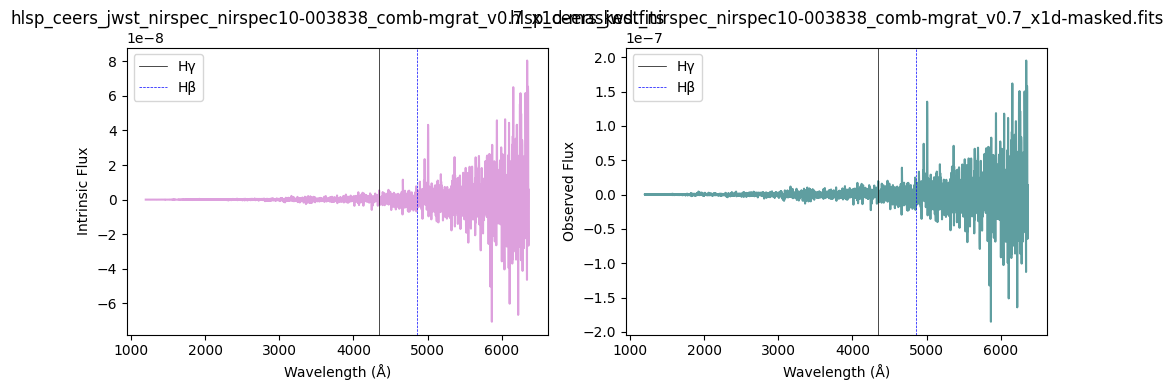

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1016719245862545
0.22608753684079372
[4.85394637 4.8517784  4.84961572 ... 1.30899664 1.30840906 1.30782189]


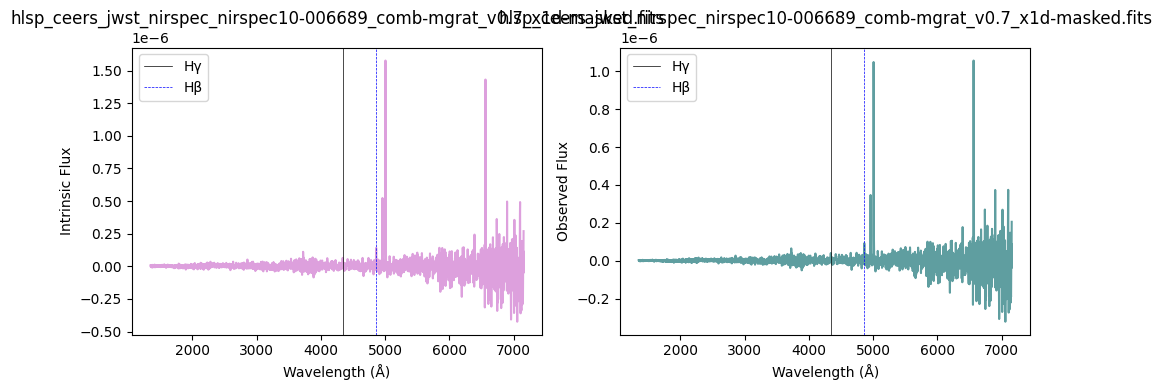

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.3280186360995746
-2.6026961371832935
[5.1864237  5.18359597 5.18077623 ... 1.46823468 1.46759439 1.46695455]


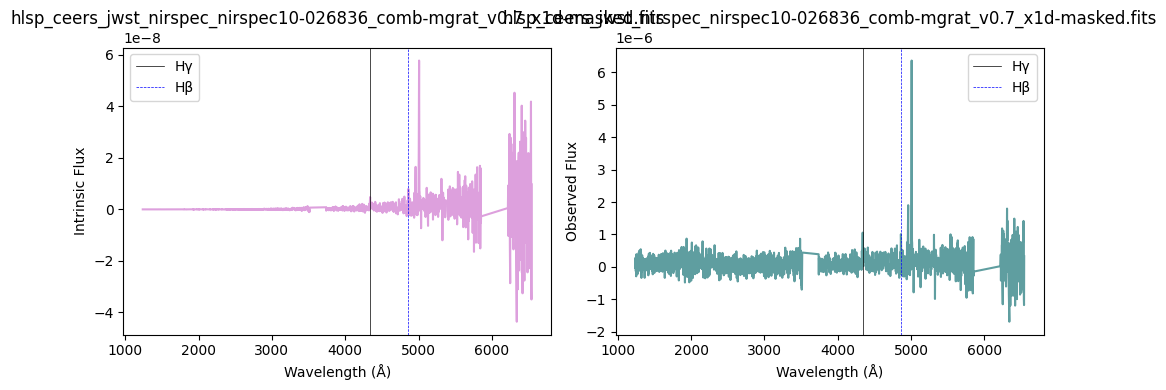

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.526709147891478
0.9879371389822272
[0.         0.         0.         ... 1.86590249 1.86523134 1.86456052]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7153468380621104
-0.7821684846853975
[0.         0.         0.         ... 1.74673417 1.74607742 1.745421  ]


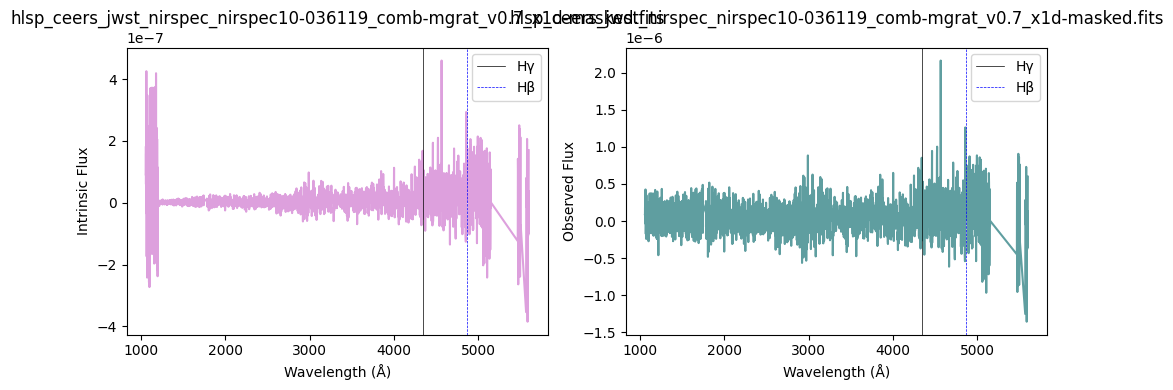

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2318134359363393
0.4868007356070198
[0.         0.         0.         ... 1.68704589 1.68640357 1.68576158]


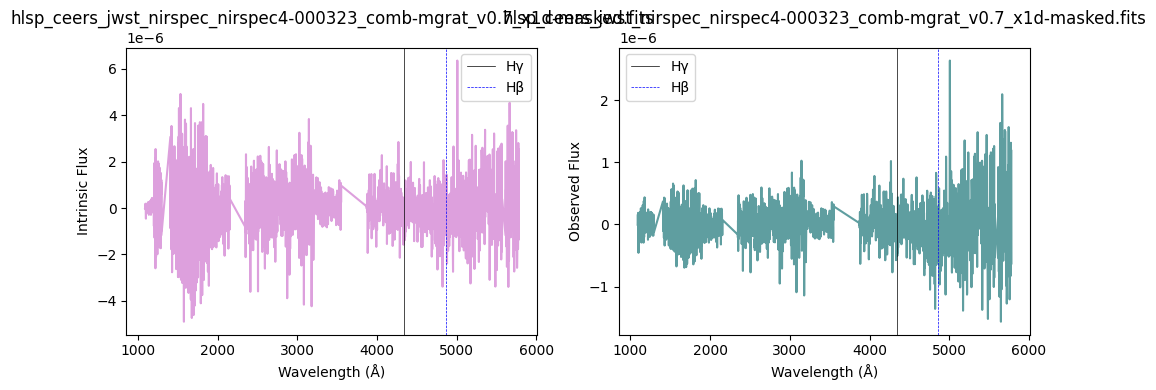

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0645604249130556
0.14607697428911695
[5.32173712 5.31871868 5.3157088  ... 1.57683706 1.576217   1.57559726]


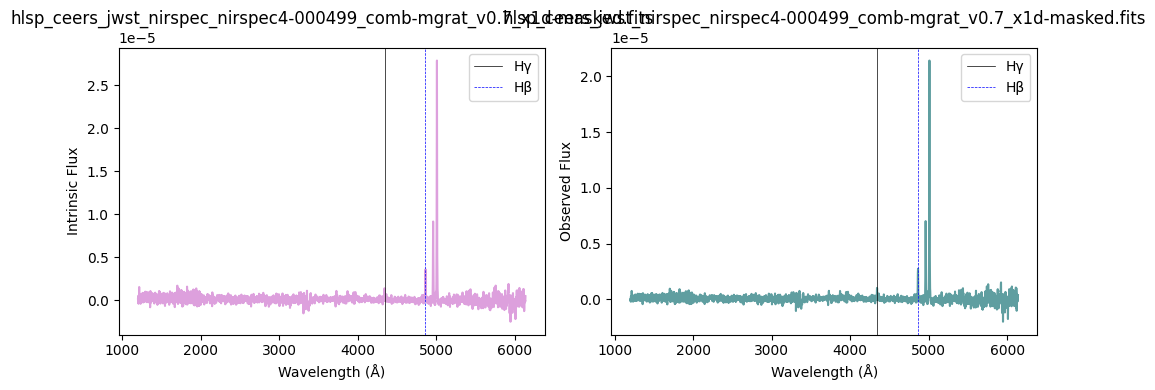

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


2.00632028727817
1.6258078743206503
[0.         0.         0.         ... 1.64360616 1.64296792 1.64233001]


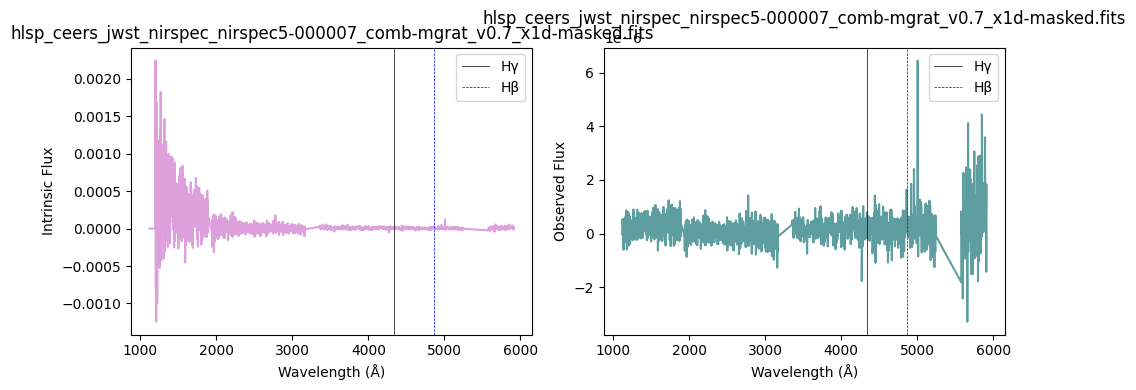

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1159216349720884
0.2560951481923734
[4.82726286 4.82514091 4.82302408 ... 1.29328456 1.29270749 1.29213082]


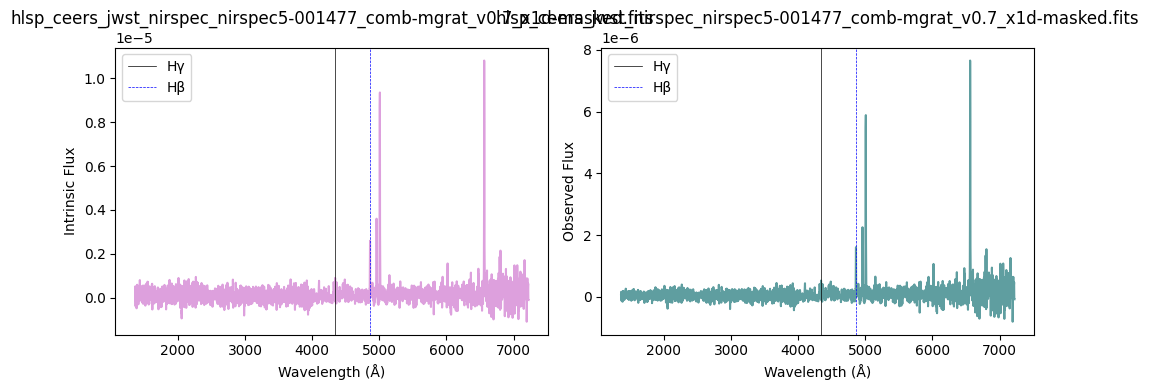

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


2.8347815287776847
2.432901044455155
[4.87455742 4.87235124 4.87015054 ... 1.3171796  1.31659482 1.31601043]


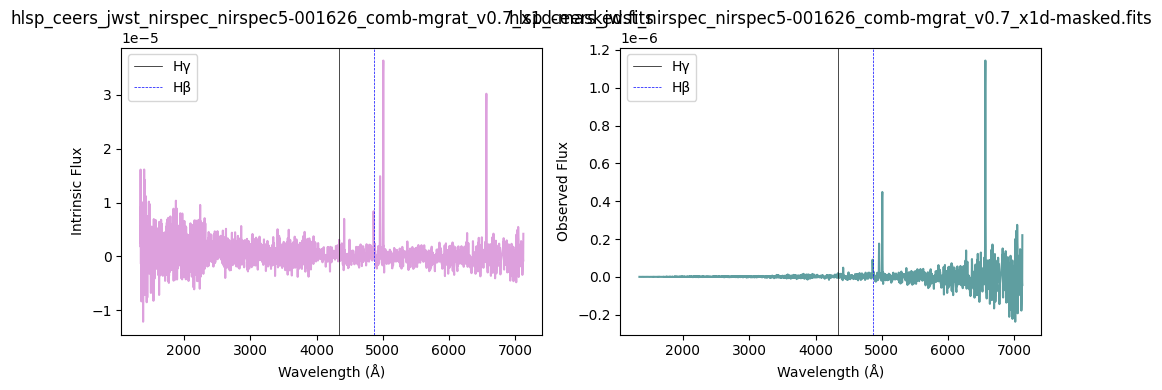

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.529116645827468
-1.4862826639687174
[5.16165237 5.15887879 5.15611301 ... 1.46616633 1.46552463 1.46488338]


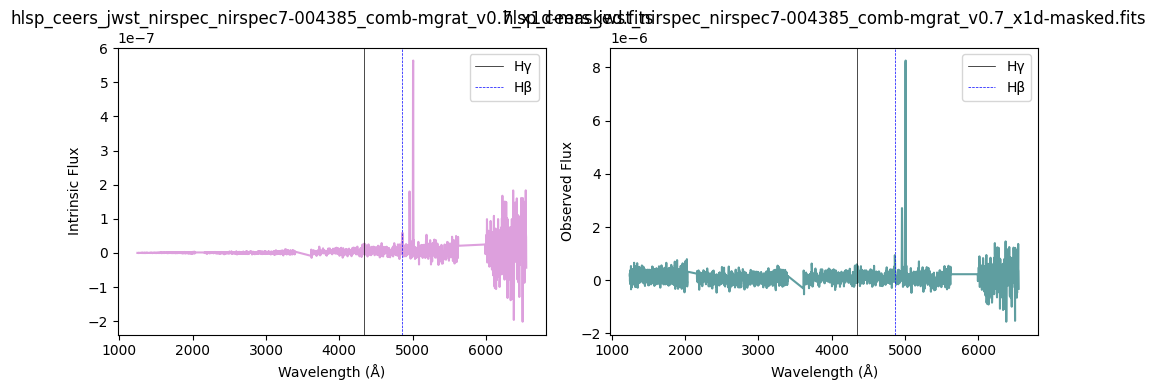

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0499839734877043
0.11388532383237127
[0.         0.         0.         ... 1.7251951  1.7245435  1.72389223]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.5822944455394593
-1.262673938563657
[0.         0.         0.         ... 1.83457408 1.8339089  1.83324404]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.4222468990554267
0.8224462125945128
[0.         0.         0.         ... 1.59549873 1.59487352 1.59424864]


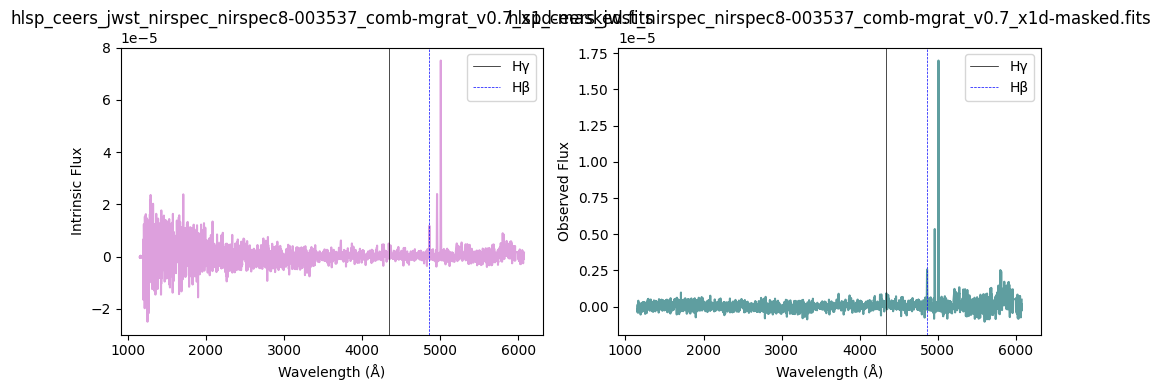

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8644045806990213
-0.34023086207599035
[0.         0.         0.         ... 1.82793705 1.82727003 1.82660334]


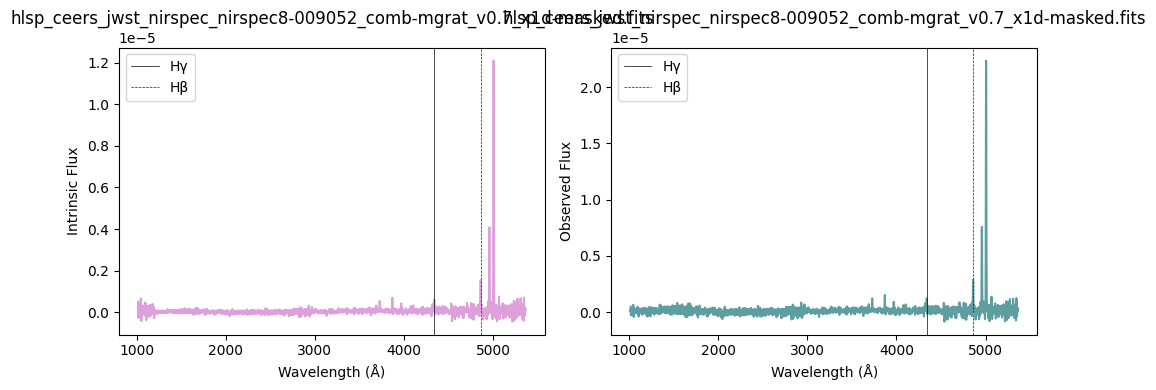

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0554865839779308
0.12608987888080342
[4.89195065 4.88970994 4.88747485 ... 1.32650195 1.32591157 1.32532161]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.05179260717484356
-6.91253885264879
[0.         0.         0.         ... 1.93801957 1.93733576 1.93596915]


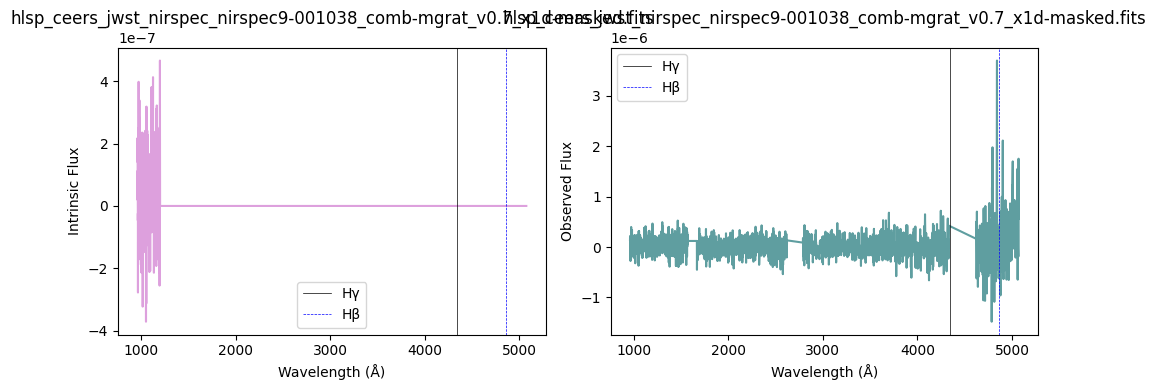

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.37561849892735133
-2.286306597871123
[5.039129   5.03659852 5.03407487 ... 1.39904539 1.39842961 1.39781426]


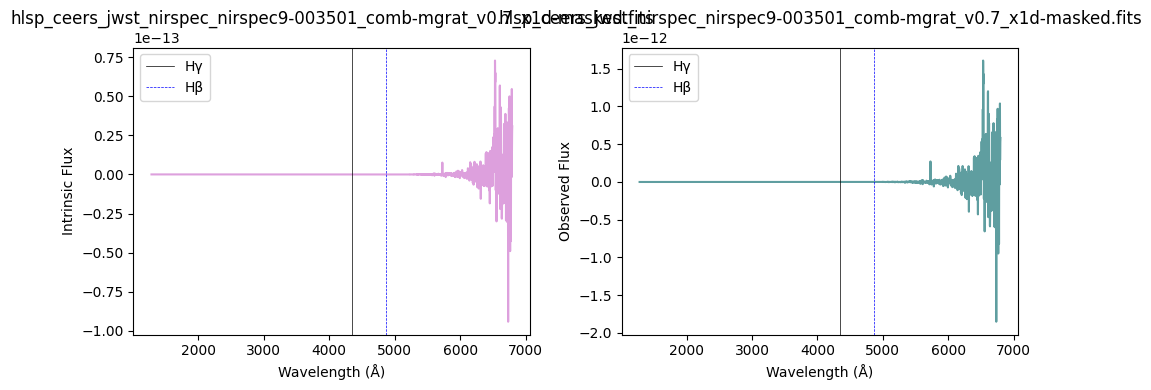

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.013856247397438187
-9.991152532866508
[4.74944877 4.7474585  4.74547274 ... 1.25343106 1.25286238 1.2522941 ]


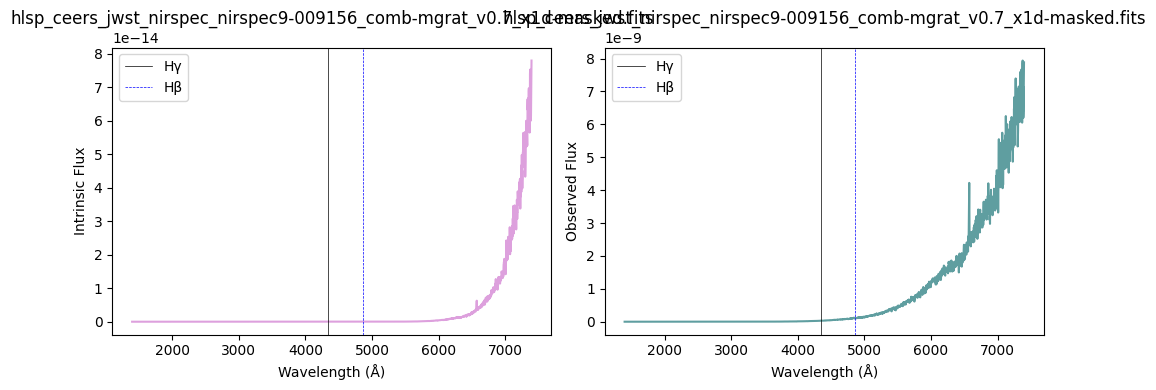

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1559313060181917
0.33834422507167383
[0.         0.         0.         ... 1.93732111 1.93662289 1.93592501]


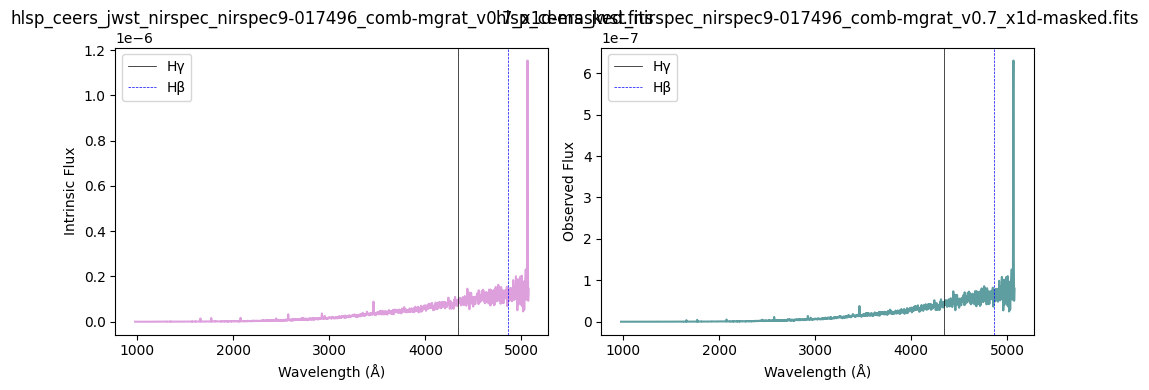

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.048239267999643544
-7.078490811622363
[5.06536161 5.062776   5.06019745 ... 1.41357833 1.41295405 1.4123302 ]


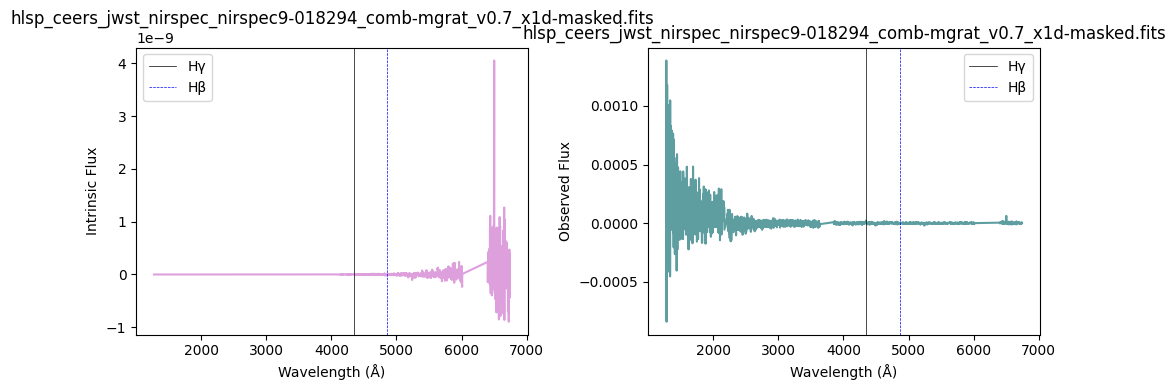

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.3753458797956861
0.7441501652998086
[2.64319058 2.64192257 2.64065539 ... 1.57155621 1.57093464 1.57031339]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7164532081716402
-0.778560044496363
[2.59570111 2.59436977 2.59303936 ... 1.4338555  1.43323506 1.43261505]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7106833410794436
-0.7974401323027993
[2.52347196 2.52213744 2.5208039  ... 1.37379652 1.37318967 1.37258324]


/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.49603996403156675
-1.6370071648635993
[2.4320688  2.43074309 2.42941838 ... 1.29822329 1.29764228 1.29706167]


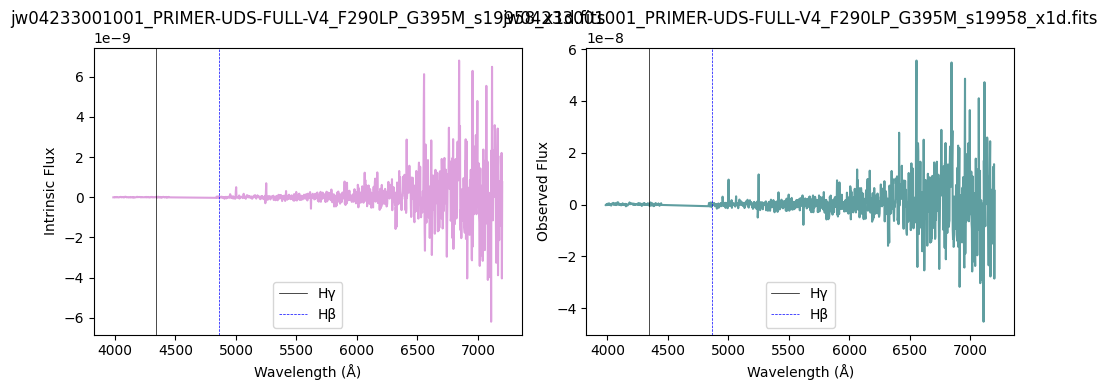

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.4976185926492889
-1.6295881793524774
[2.526982   2.52564857 2.52431611 ... 1.37611756 1.37550733 1.37489752]


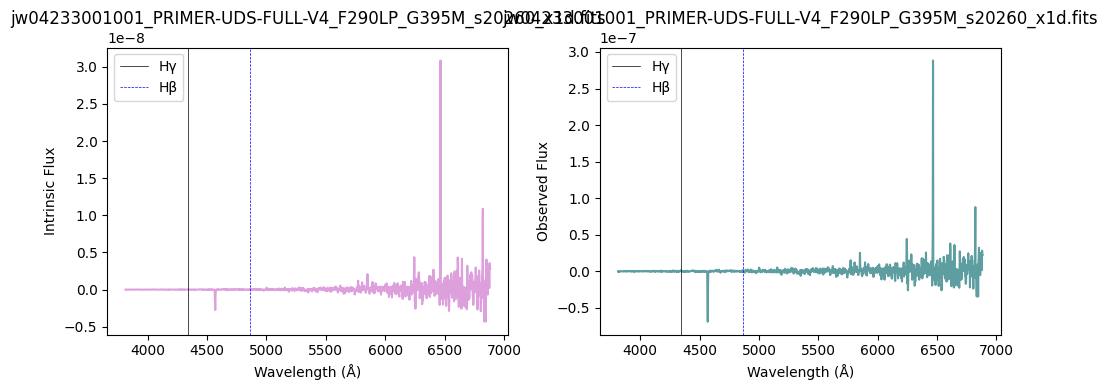

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.735081410402072
-0.7186266669786138
[2.51028823 2.50895065 2.50761404 ... 1.36221386 1.36160675 1.36100007]


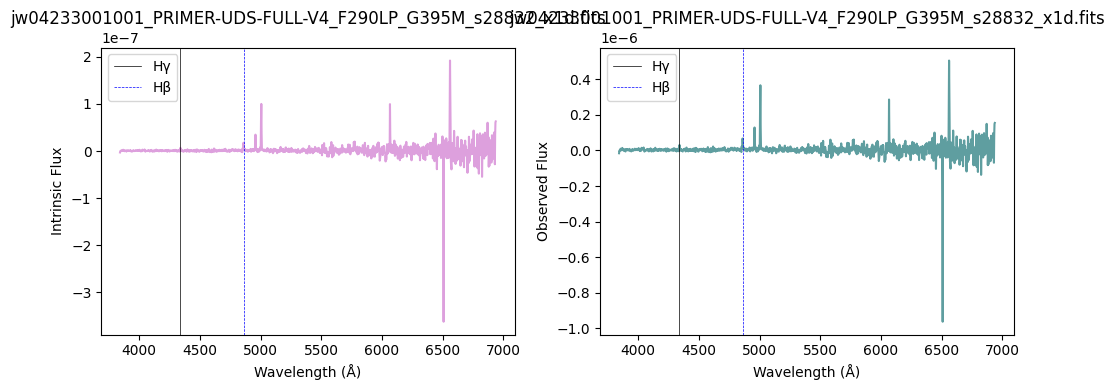

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2660551831540958
0.5508206212505239
[2.65937711 2.6580344  2.65669262 ... 1.48993929 1.48929398 1.48864912]


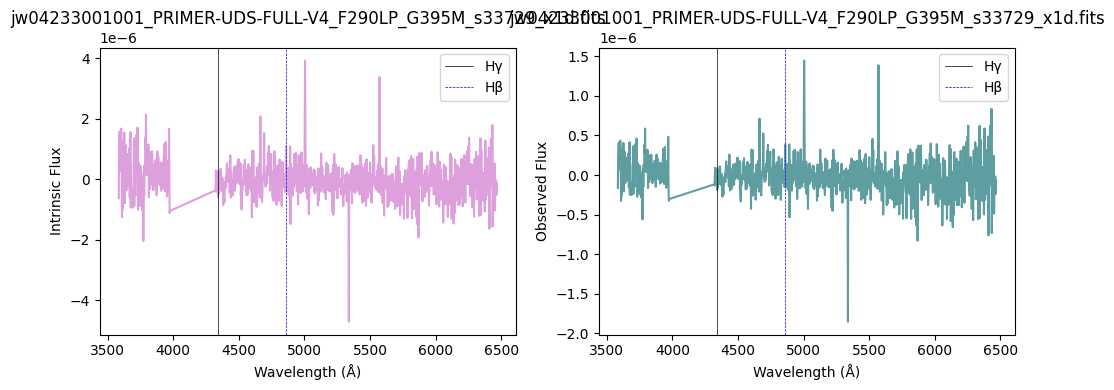

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1630479230949868
0.35267532307110994
[2.51904551 2.51770863 2.51637272 ... 1.36973451 1.36912633 1.36851858]


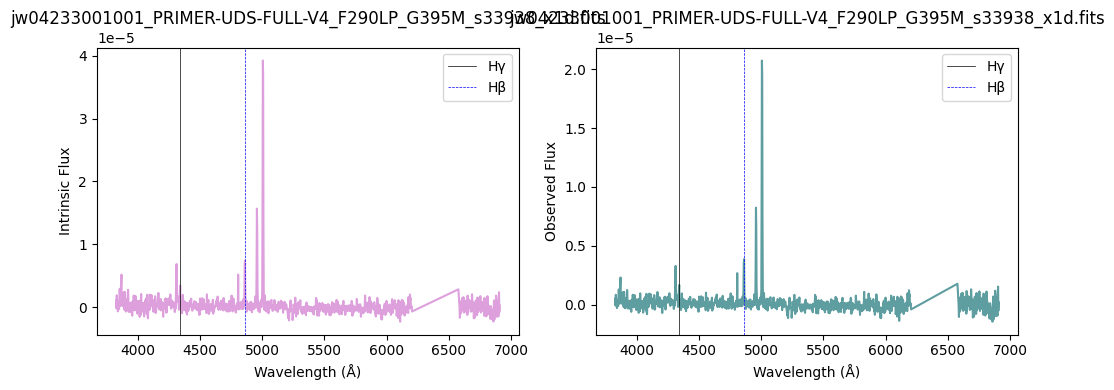

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.5283308635757171
0.9904160401837777
[2.7627995  2.76145186 2.76010511 ... 1.566573   1.56595475 1.56533682]


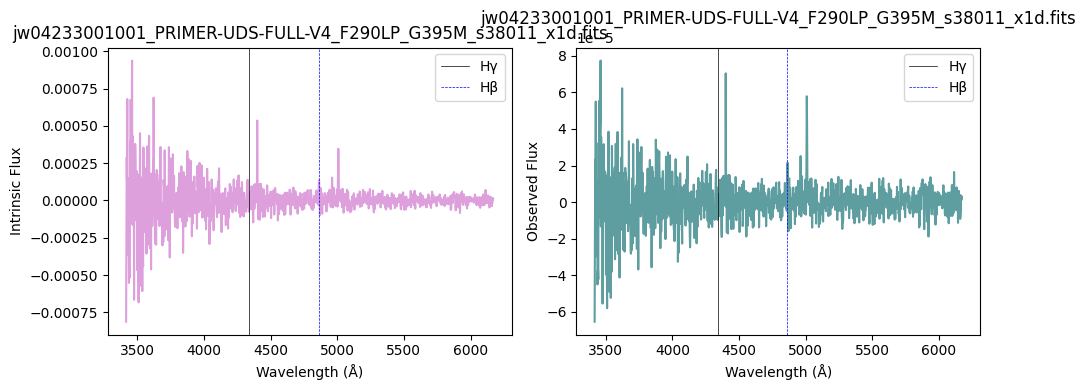

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8924535830289696
-0.2656686156361589
[2.72501411 2.72367101 2.72232881 ... 1.53481918 1.53420754 1.53359622]


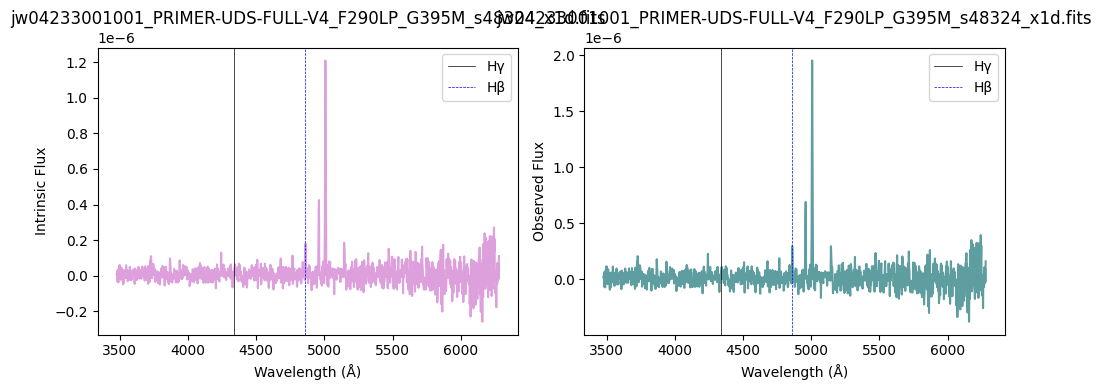

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8643981472367314
-0.34024824011161753
[2.57291801 2.57157534 2.57023363 ... 1.41508733 1.41446161 1.41383632]


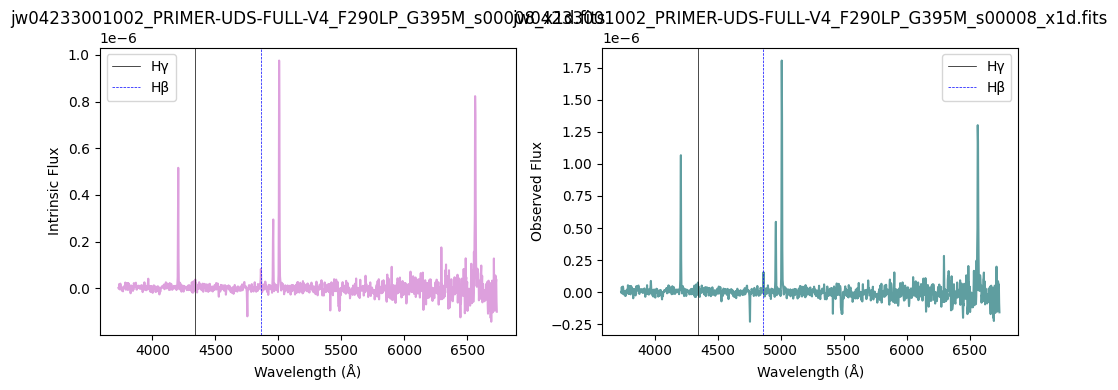

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.5580616119860082
-1.3619239288204614
[2.60262505 2.60128365 2.5999432  ... 1.43922009 1.43859216 1.43796466]


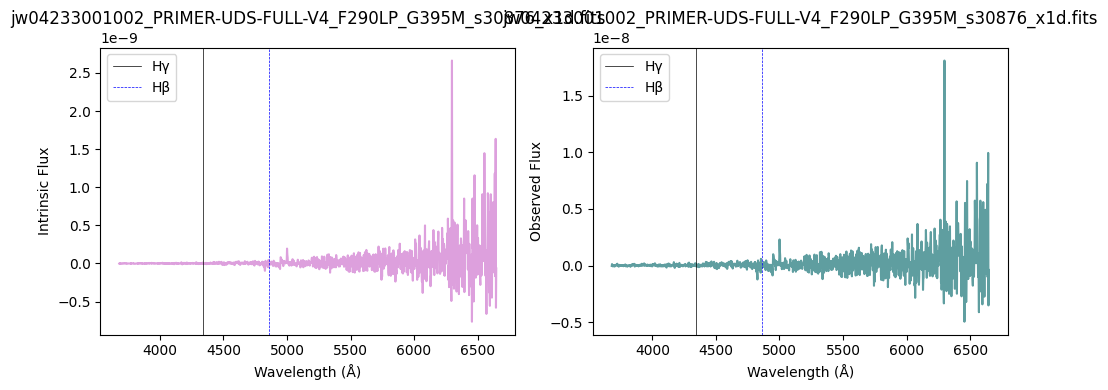

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9871445186934847
-0.030211084085066054
[2.67647491 2.6751281  2.67378222 ... 1.50307358 1.5024205  1.50176788]


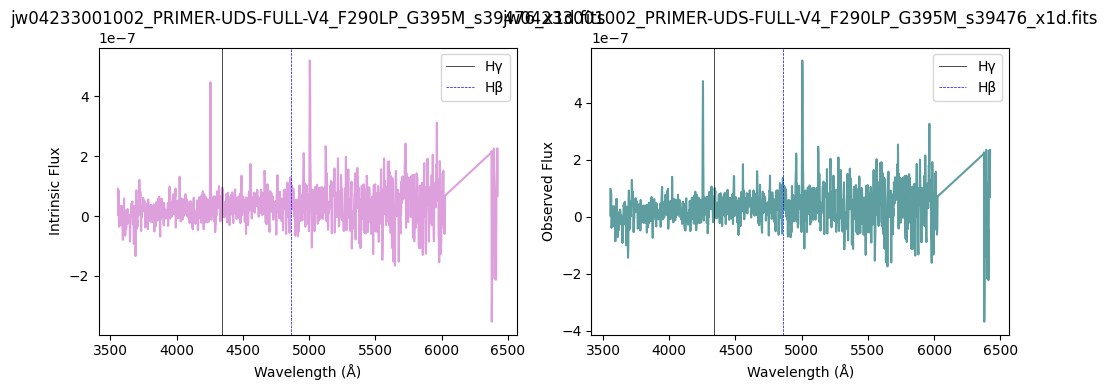

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.25236521968733405
-3.2148951539262507
[3.13453602 3.13318572 3.13183619 ... 1.88890181 1.8882282  1.88755492]


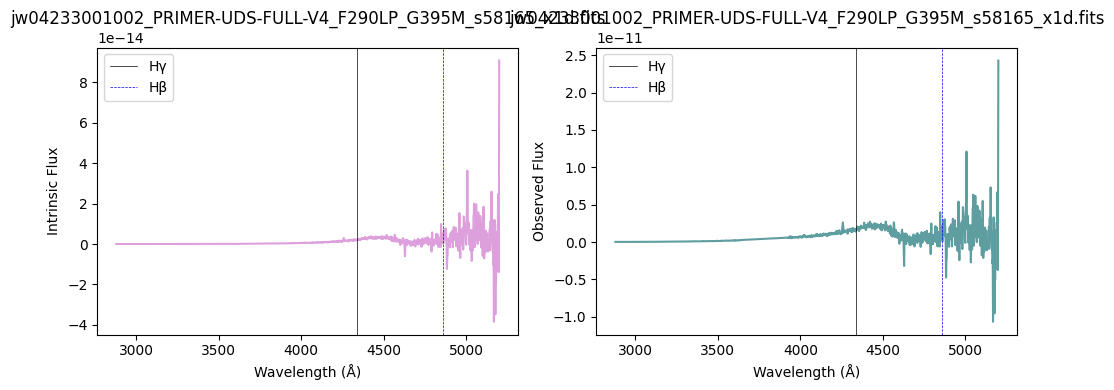

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0285312091086352
0.06568534511396214
[3.00788634 3.00653031 3.0051751  ... 1.7764642  1.77580421 1.77514454]


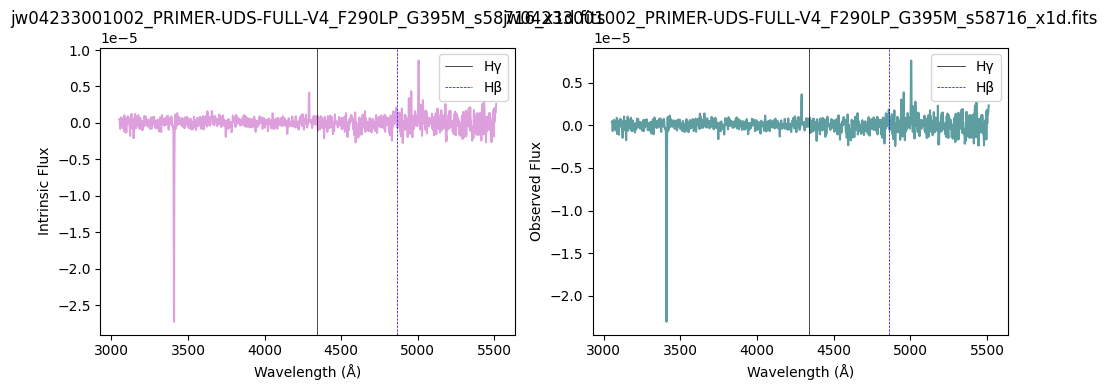

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6337679947058833
-1.0648908412387563
[2.42367474 2.42235228 2.42103081 ... 1.29170848 1.29112923 1.29055038]


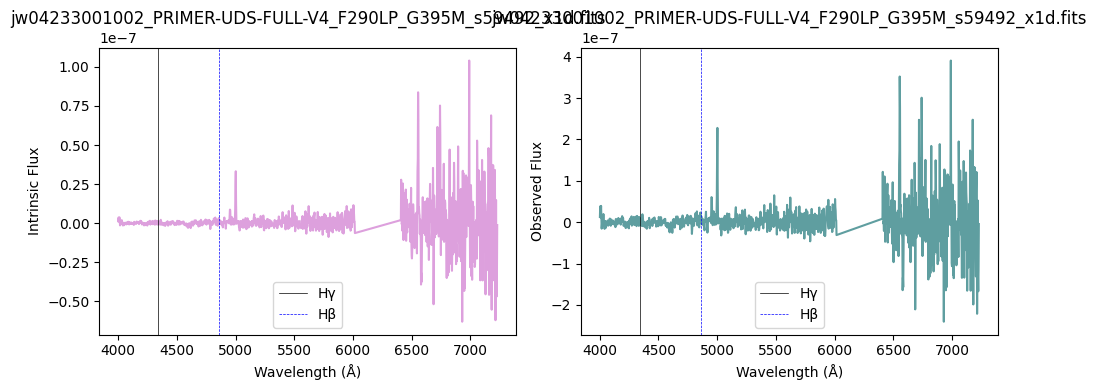

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.5531526061417849
1.0280329556239667
[2.69991248 2.69856541 2.69721925 ... 1.60314513 1.60248353 1.60182228]


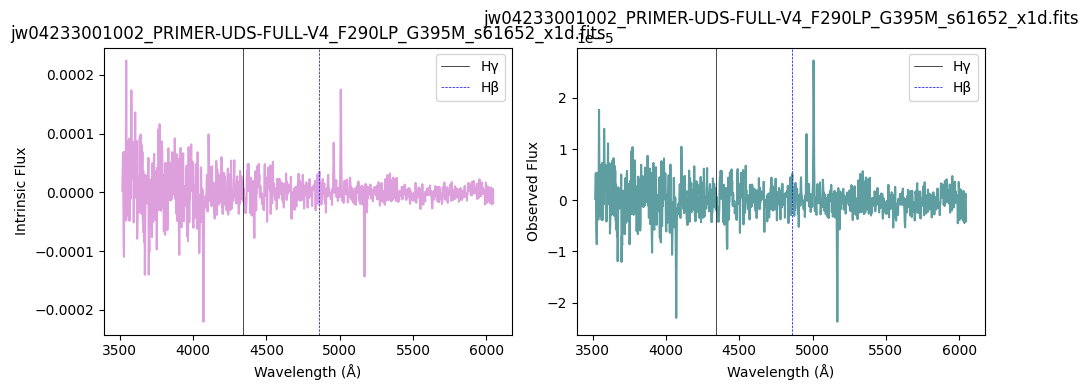

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.3486400317788088
0.6983658426140369
[2.70196771 2.7006174  2.699268   ... 1.58349469 1.58284299 1.58219164]


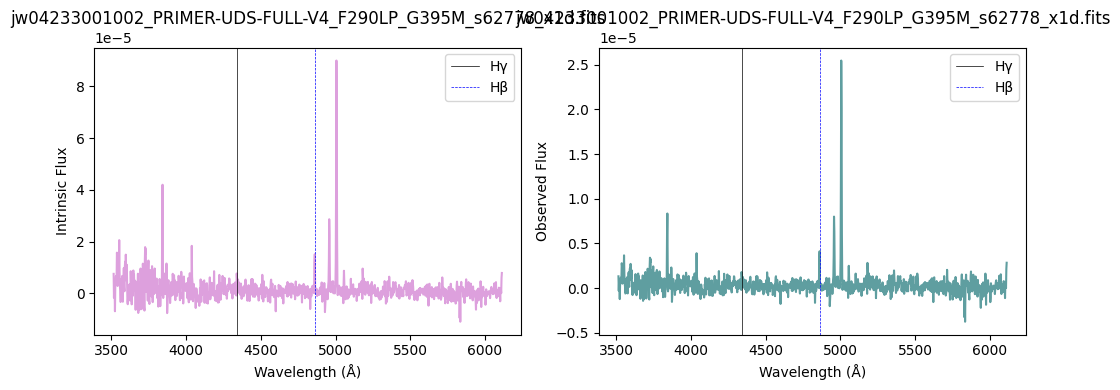

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.34852075397364674
-2.461136317765548
[2.38559135 2.38427886 2.38296737 ... 1.26277752 1.26221151 1.26164589]


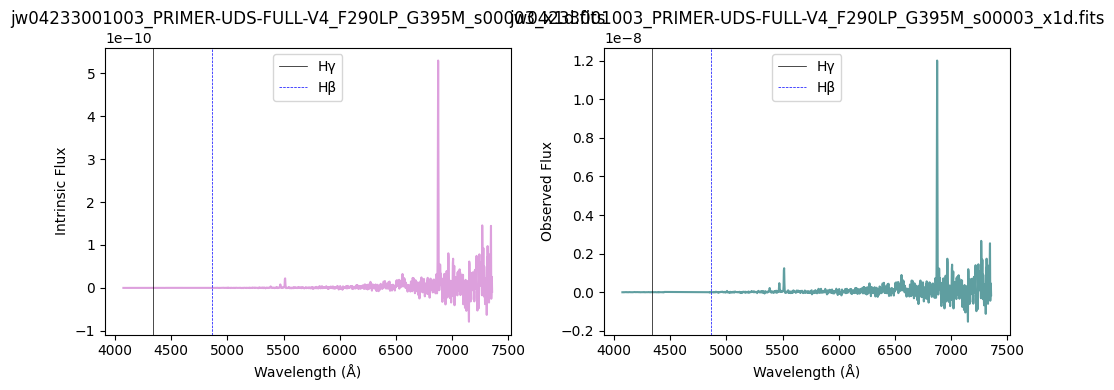

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8038453189627233
-0.509825338295751
[2.41768868 2.41636846 2.41504924 ... 1.2883974  1.2878179  1.2872388 ]


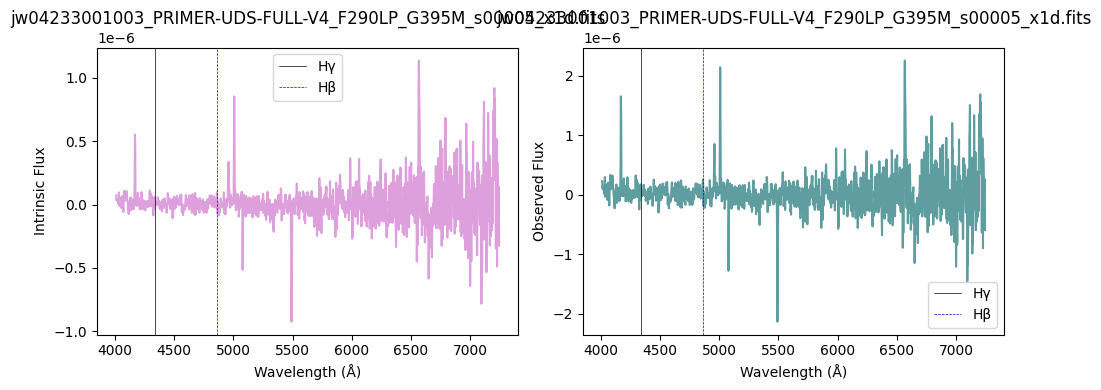

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.70750639304158
-0.8079012445834672
[2.52353017 2.52219952 2.52086984 ... 1.37281877 1.37221325 1.37160815]


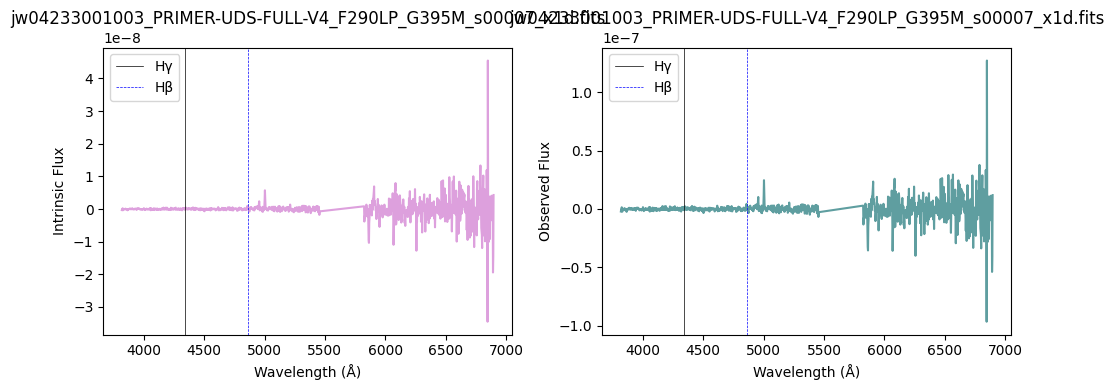

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7695441292883599
-0.6116476915341263
[2.80625739 2.80490387 2.80355124 ... 1.60354862 1.60292012 1.60229194]


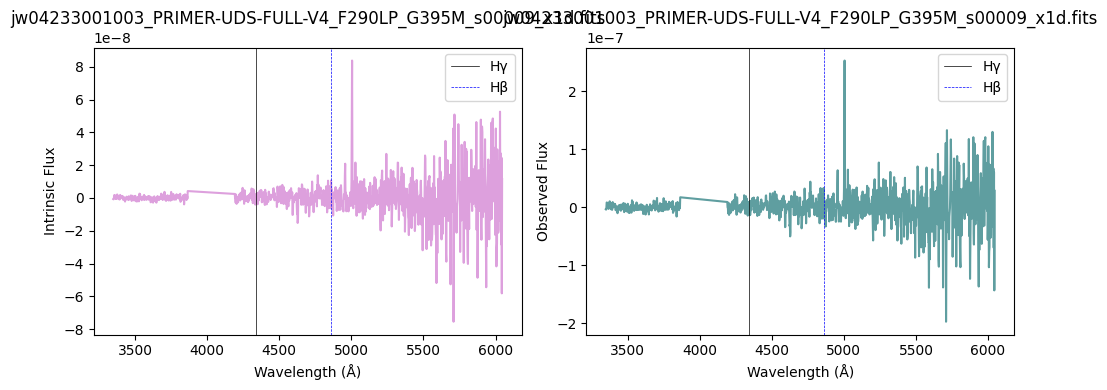

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8618215309391484
-0.3472186027255388
[2.72769676 2.72634909 2.72500233 ... 1.53819889 1.53758452 1.53697047]


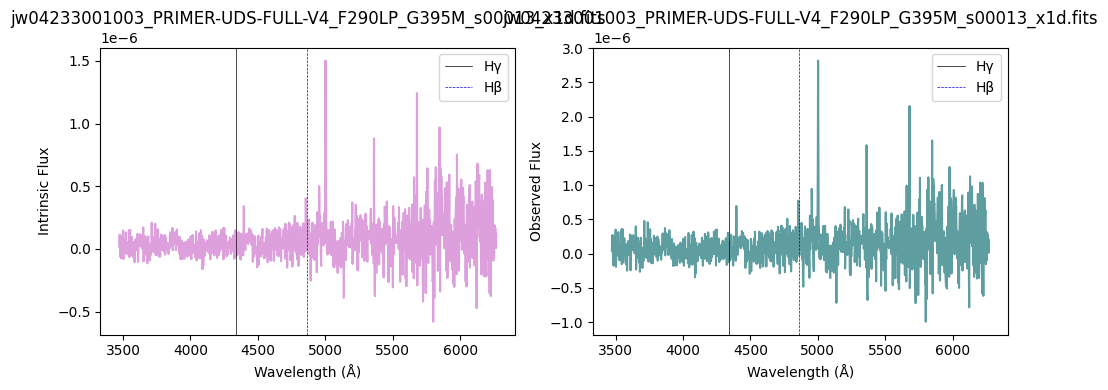

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9856865613843085
-0.0336621745841392
[2.68575516 2.68445854 2.68316277 ... 1.5720067  1.57138468 1.57076298]


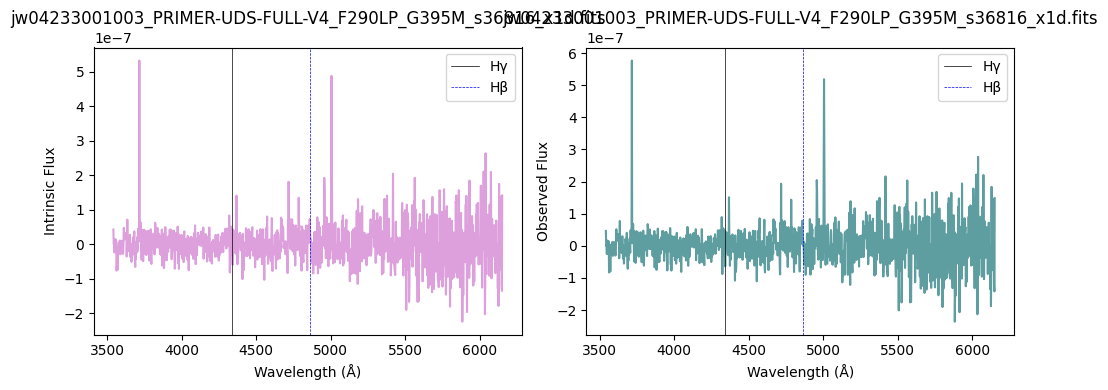

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7538867319069141
-0.6596446237787335
[2.6445768  2.643235   2.64189413 ... 1.4762247  1.47558083 1.4749374 ]


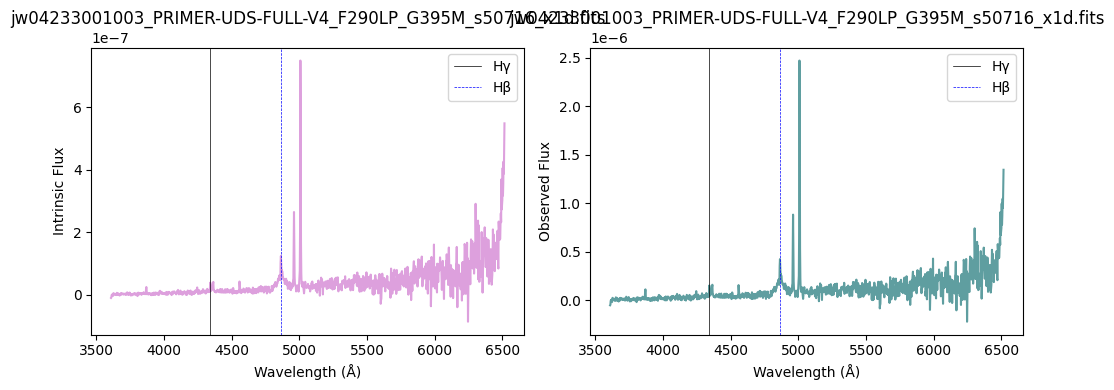

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7140417829807592
-0.7864321195503238
[2.63239649 2.6310519  2.62970824 ... 1.46433059 1.46369321 1.46305626]


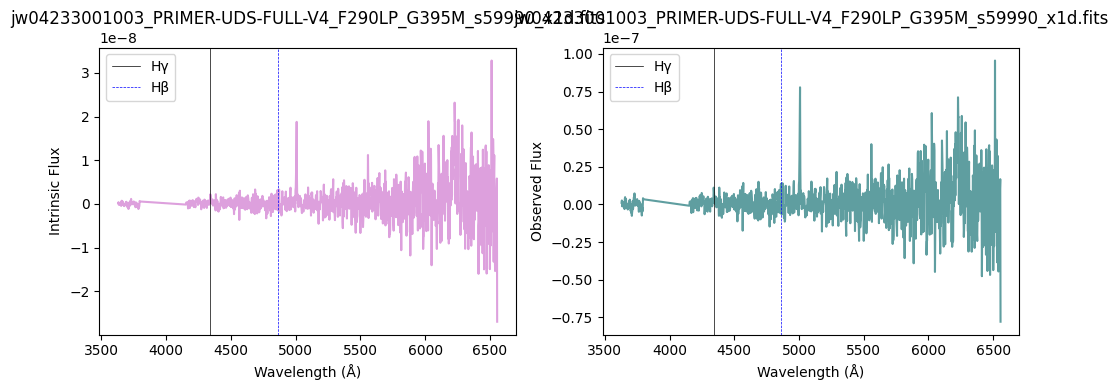

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2544896979451199
0.5293930063160011
[2.55950883 2.55817425 2.55684063 ... 1.40400288 1.40338493 1.40276741]


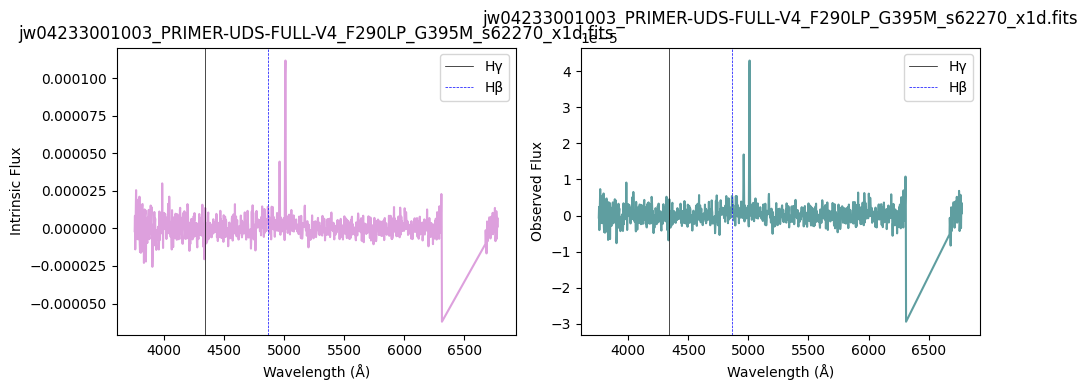

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7038057569094187
-0.8201461564205541
[2.55863439 2.55729277 2.55595212 ... 1.40352101 1.40290065 1.40228072]


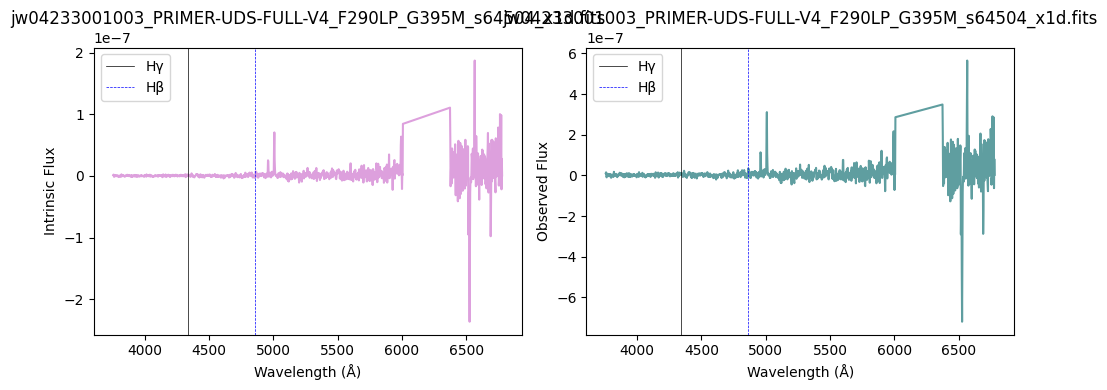

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9859089606477136
-0.03313540961481327
[2.41881229 2.41749269 2.41617409 ... 1.28863633 1.28805827 1.2874806 ]


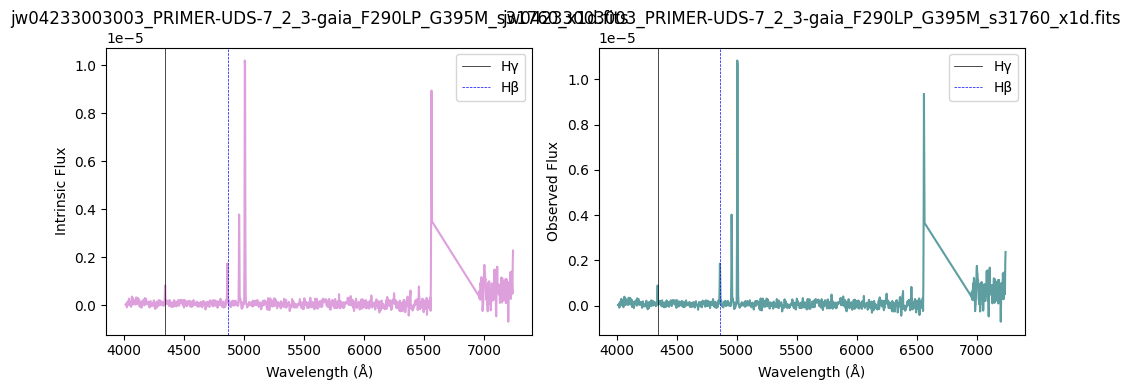

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2112173356665559
0.44743052732645416
[2.51181081 2.51048009 2.50915033 ... 1.36412256 1.36351897 1.36291579]


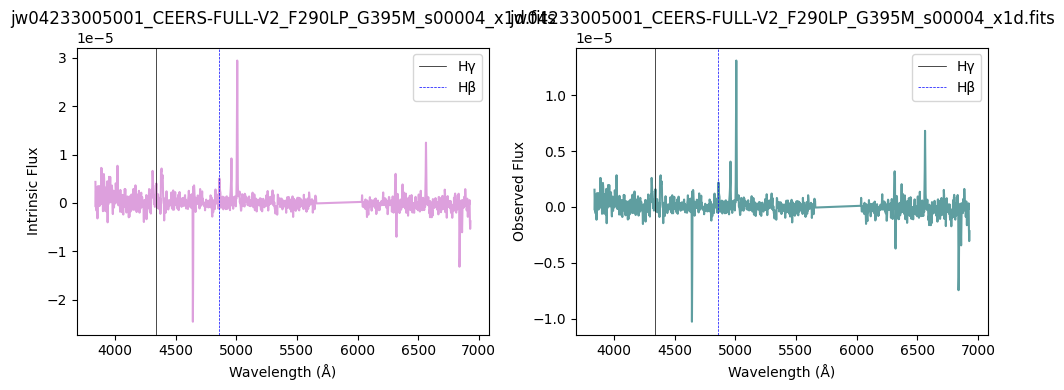

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6434003936435994
-1.0296703103495572
[2.84780058 2.84645276 2.84510579 ... 1.63769504 1.63706594 1.63643716]


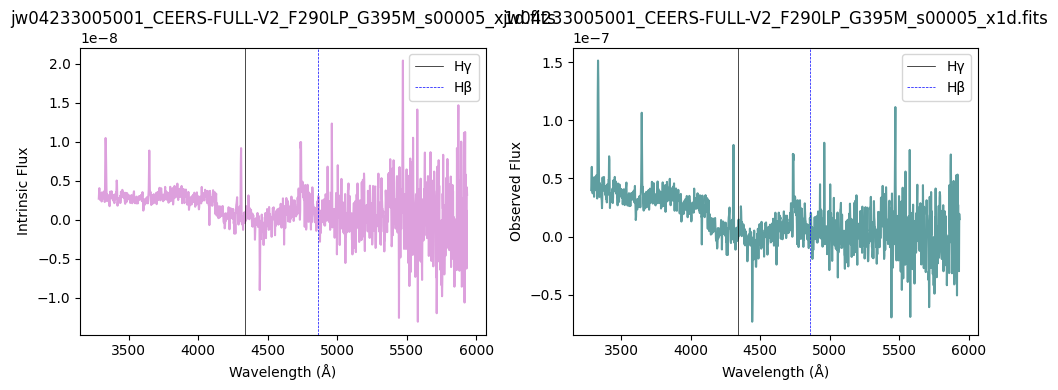

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.4945954950277353
-1.6438163638891765
[2.43957582 2.43825341 2.43693199 ... 1.30521525 1.30463001 1.30404518]


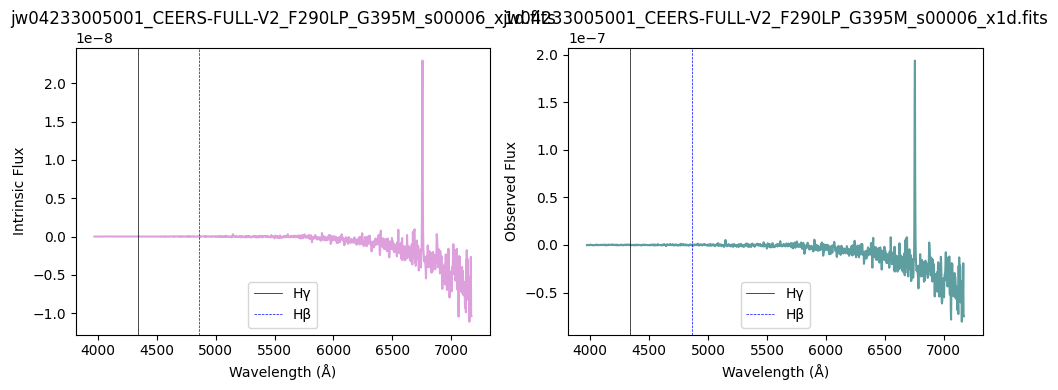

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8156392628321476
-0.47581654054627825
[2.53406137 2.5327239  2.5313874  ... 1.38330426 1.38269142 1.38207901]


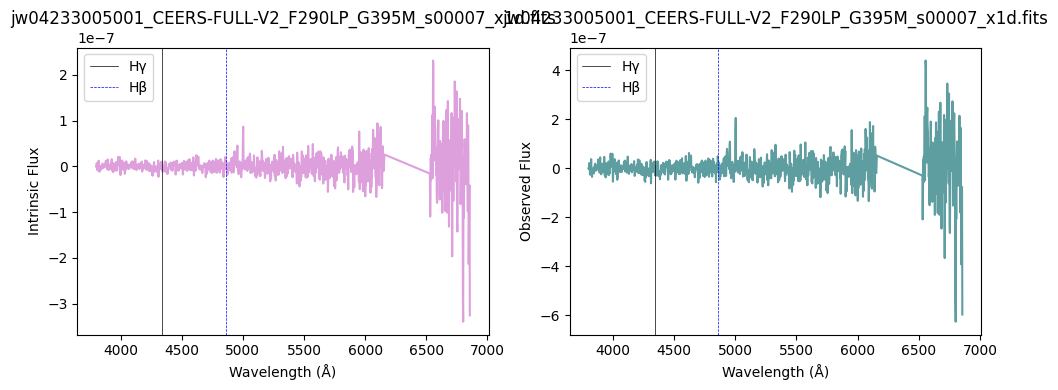

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.5248780914444993
-1.505062120560958
[2.53391425 2.53257821 2.53124316 ... 1.38122111 1.38061235 1.380004  ]


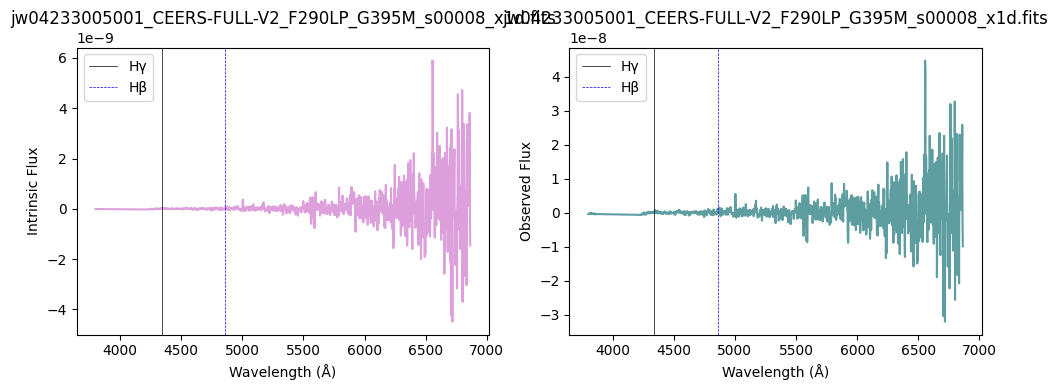

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.1782520923895282
-4.026695502879597
[2.67848946 2.67714295 2.67579737 ... 1.50571036 1.50505872 1.50440754]


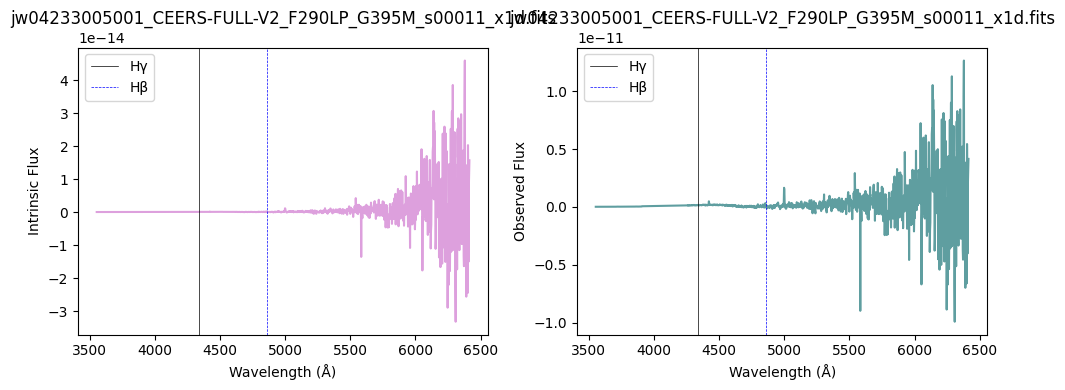

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9767934713901478
-0.05482393416299482
[2.76707324 2.76571921 2.76436608 ... 1.60548408 1.60483987 1.60419601]


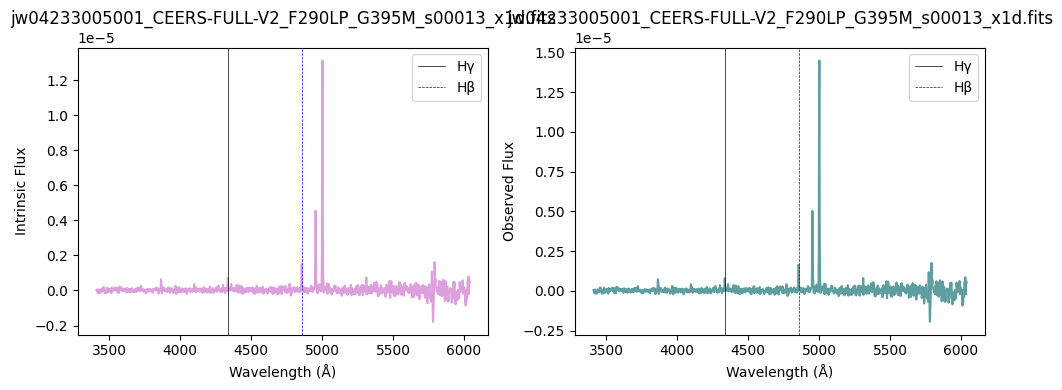

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7614333133464803
-0.6363877761179126
[2.69072634 2.68938294 2.68804045 ... 1.51753475 1.5168788  1.5162233 ]


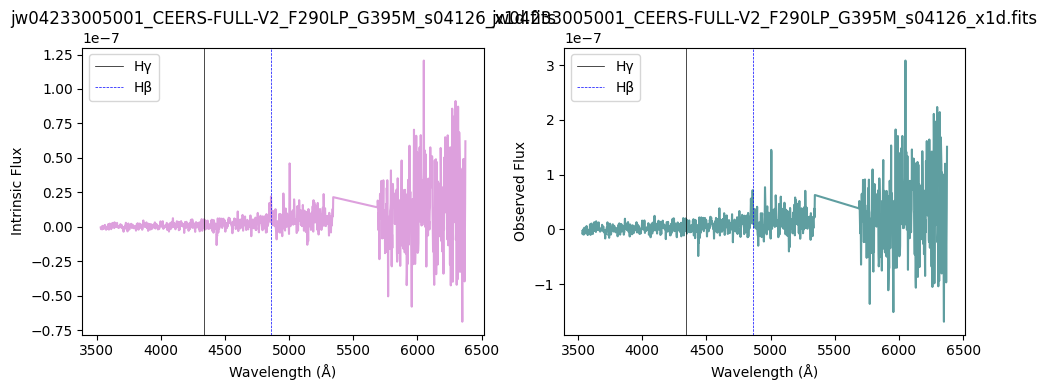

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0753090331183273
0.1695338392655947
[2.41834251 2.4170268  2.41571209 ... 1.28720702 1.28663464 1.28606266]


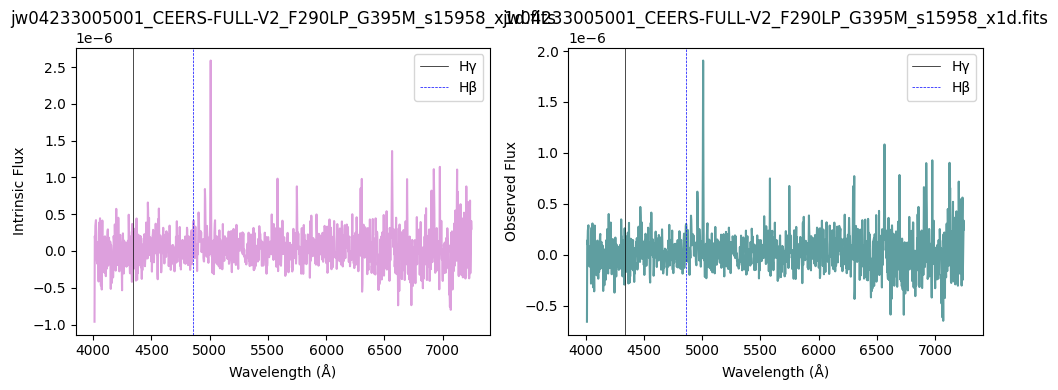

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6540219382893315
-0.9914391591671475
[2.55189139 2.55055019 2.54920994 ... 1.39716544 1.39654579 1.39592656]


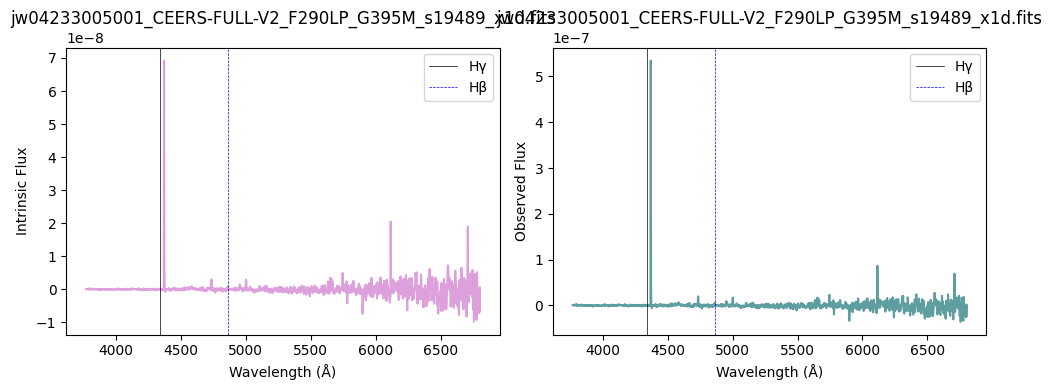

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8107828073431174
-0.48976058655844296
[2.87492056 2.87356244 2.87220517 ... 1.67182305 1.67117586 1.670529  ]


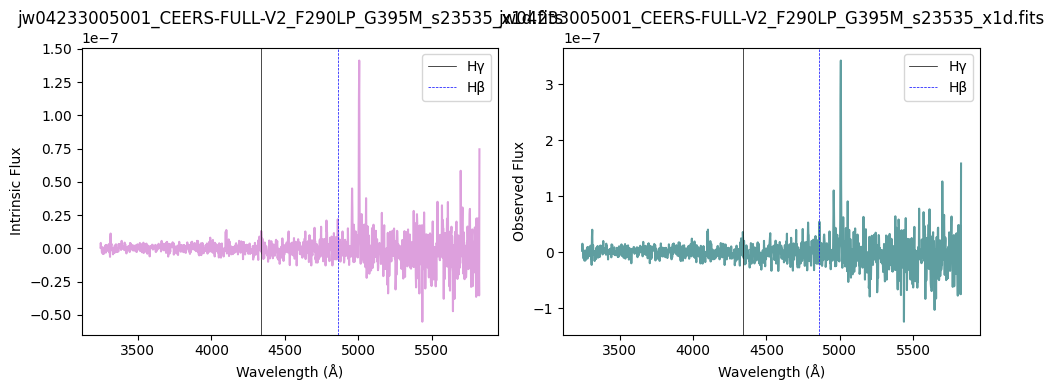

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8547182594542485
-0.36654310781627536
[2.64743984 2.64609833 2.64475775 ... 1.47852269 1.47787944 1.47723663]


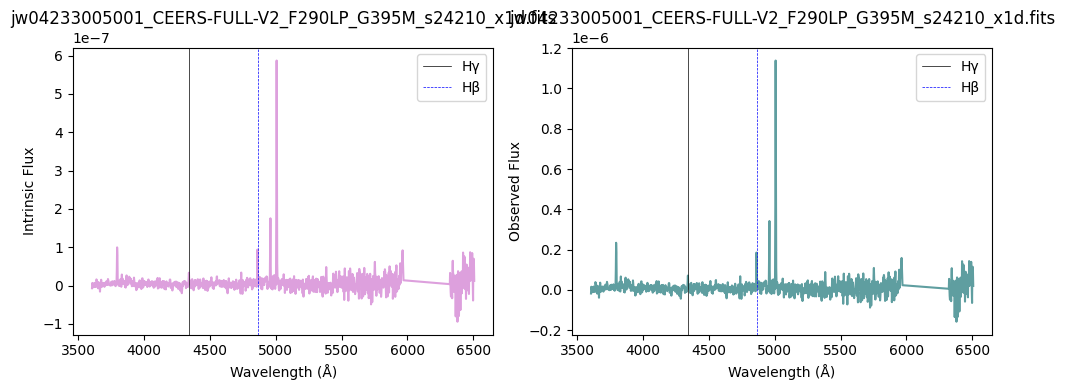

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.104980982127156
0.23309034099663653
[2.42040181 2.41908136 2.41776191 ... 1.29024303 1.28966486 1.28908708]


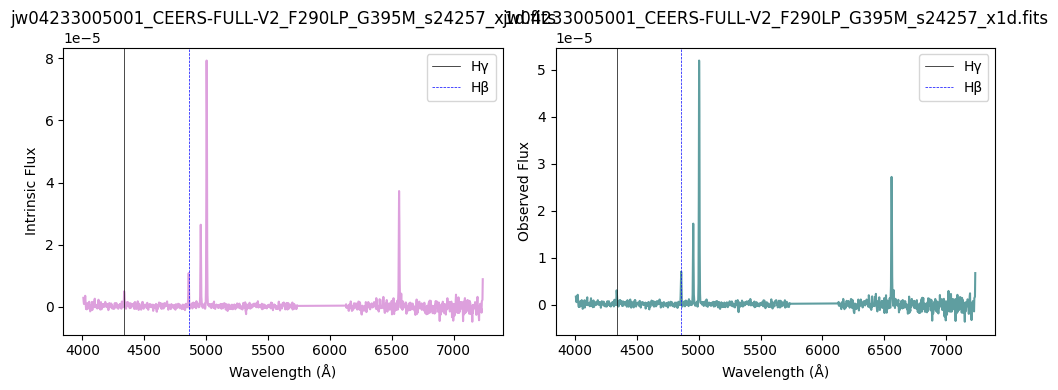

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.0287099234343764
0.06609101757967964
[2.43990137 2.43857452 2.43724867 ... 1.30643262 1.30584761 1.30526301]


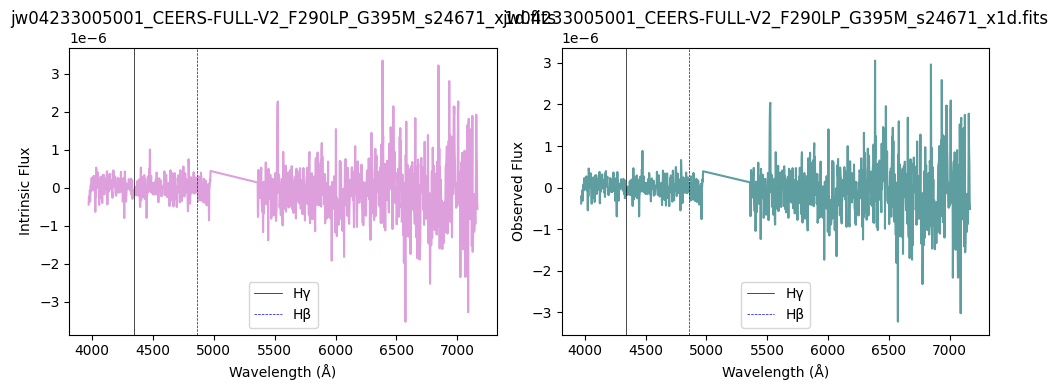

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9394654596820716
-0.14580205649939268
[2.63613322 2.63478924 2.63344621 ... 1.46937189 1.46873254 1.46809364]


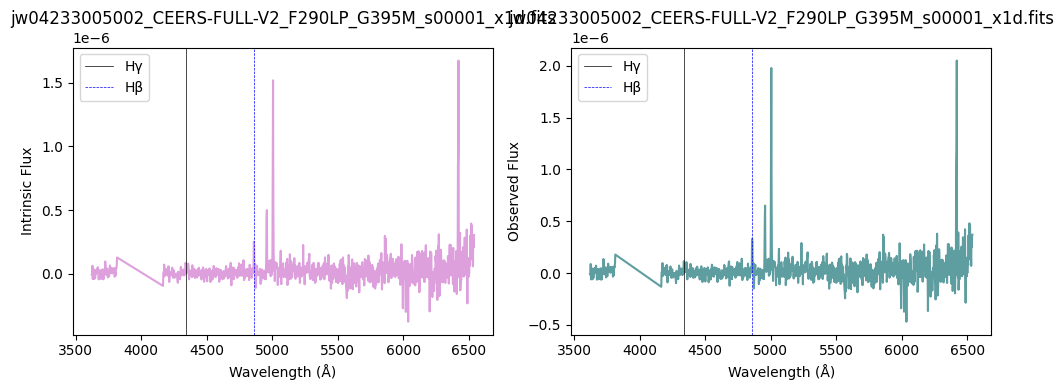

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.36471413852081586
-2.355093550995074
[2.75515593 2.75380527 2.7524555  ... 1.56029891 1.55967881 1.55905904]


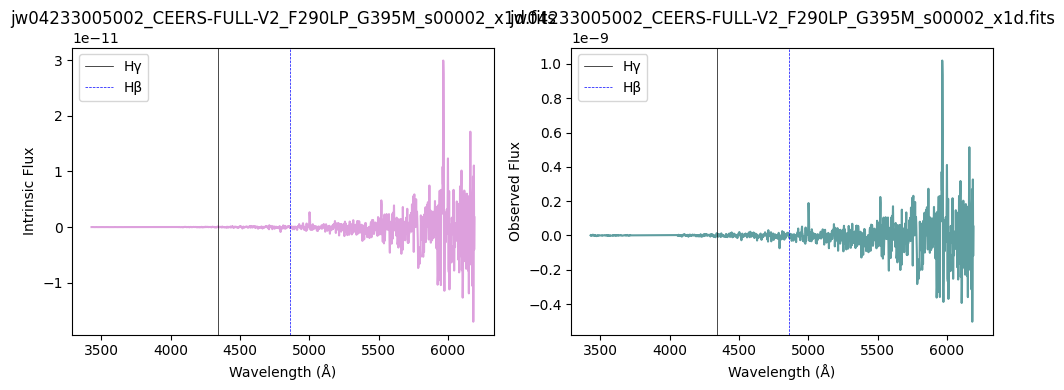

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8989505290964596
-0.2487322991102228
[3.10900928 3.10768871 3.10636889 ... 1.8972805  1.89661215 1.89594412]


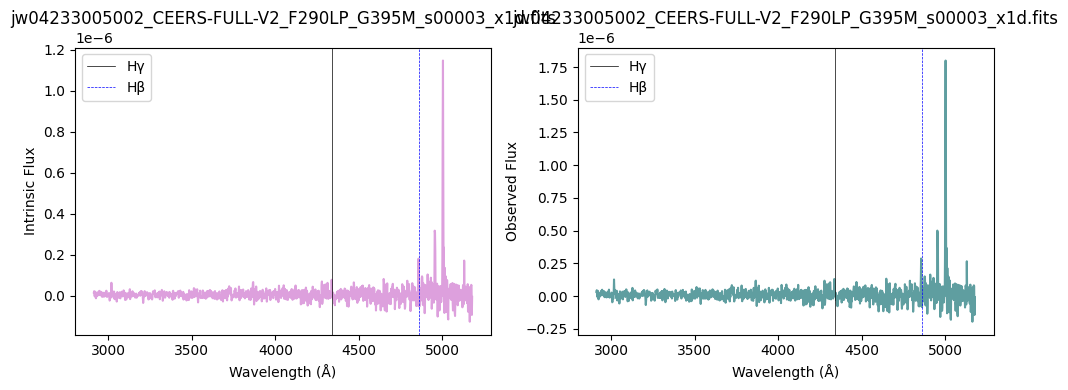

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.758881862037871
-0.6442248767742559
[2.47423684 2.47290429 2.47157273 ... 1.33414846 1.33355211 1.33295618]


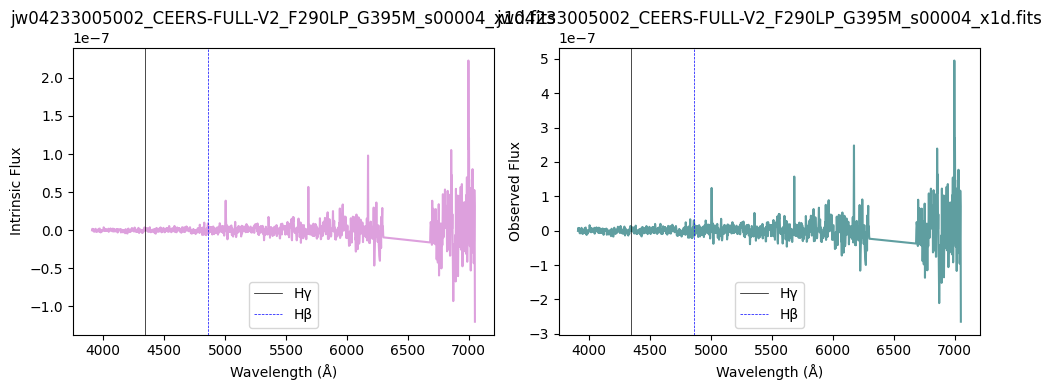

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.315214156745673
0.6397659940561999
[2.41409004 2.4127697  2.41145036 ... 1.36193817 1.36130587 1.36067404]


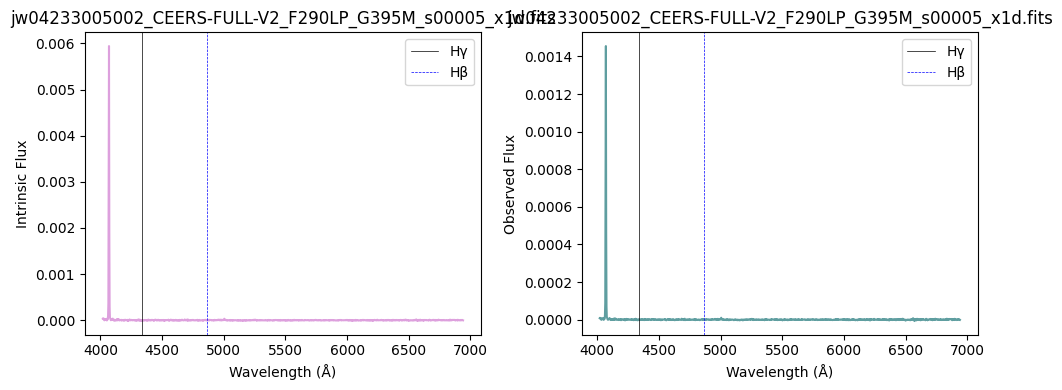

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2007701774297193
0.4272037265796847
[2.52223951 2.52091038 2.51958221 ... 1.37310426 1.37250101 1.37189817]


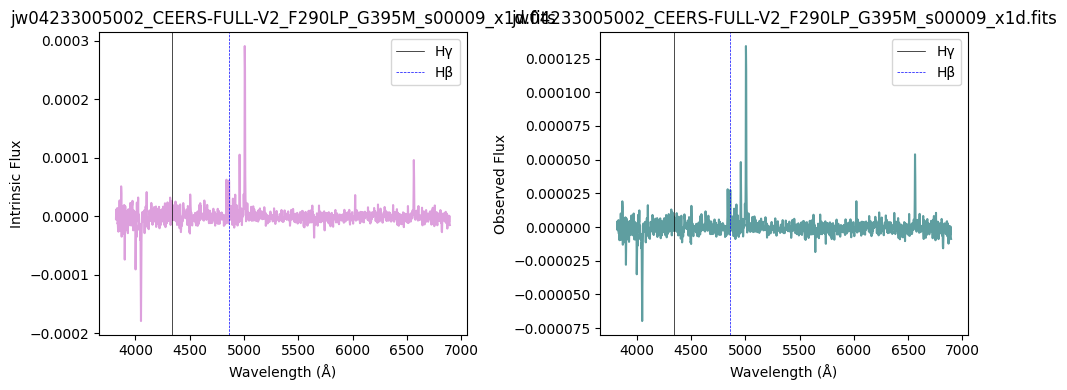

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.5648436973909068
-1.3337188860385947
[2.76643236 2.76508507 2.76373866 ... 1.56982064 1.56919698 1.56857365]


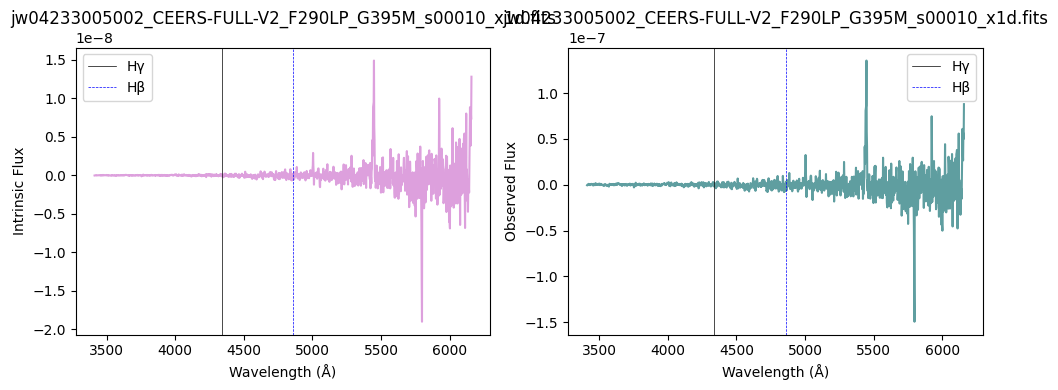

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6638080109747797
-0.9567608104224775
[2.31692052 2.31567522 2.31443084 ... 1.28196154 1.28138988 1.28081862]


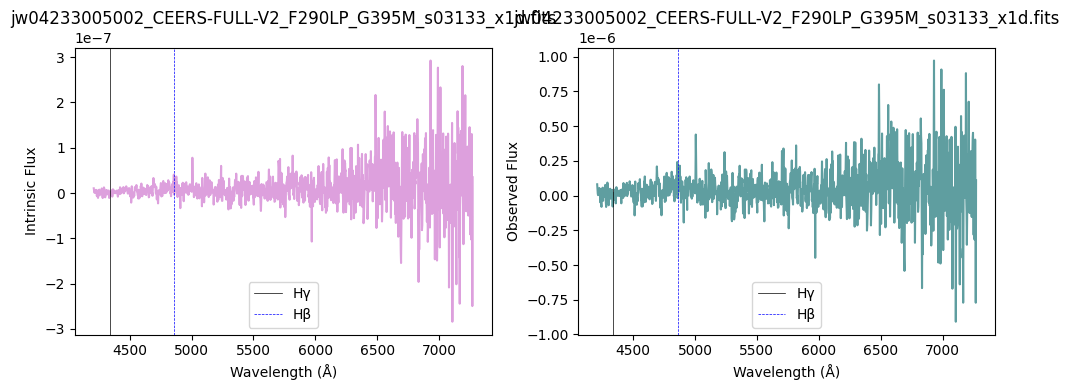

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1151114104196511
0.254399246090454
[2.42158537 2.42026422 2.41894406 ... 1.29133034 1.29075209 1.29017425]


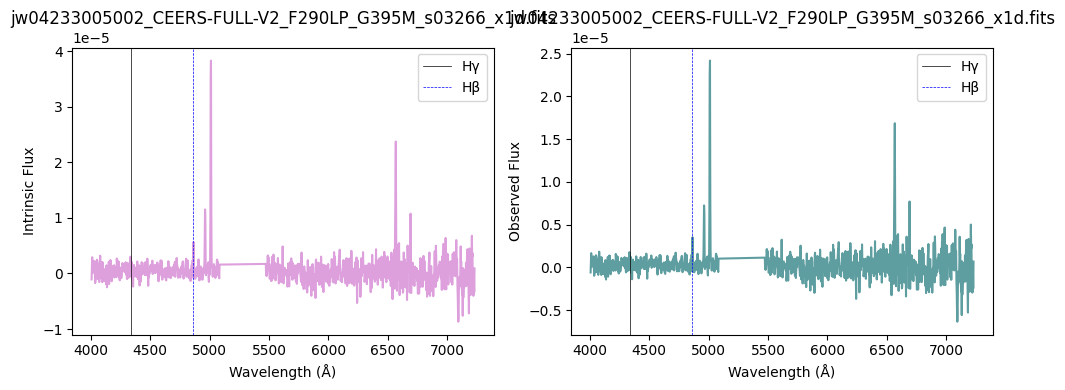

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2372710638596582
0.49712288263939125
[2.7692946  2.76794309 2.76659247 ... 1.58812521 1.58749173 1.58685859]


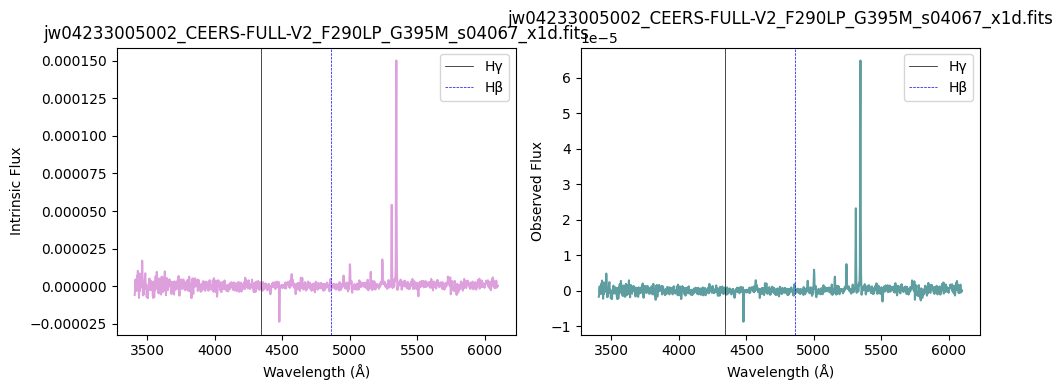

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1291980774539878
0.2837103766450002
[2.4697754  2.46845138 2.46712835 ... 1.32899182 1.32840423 1.32781705]


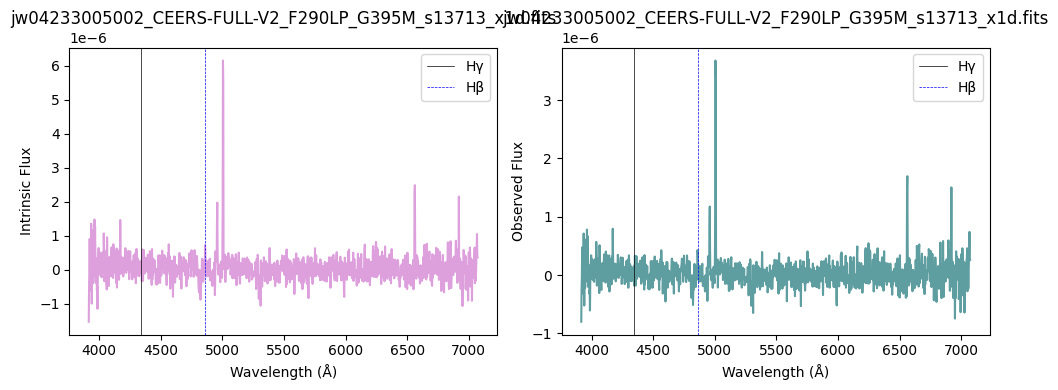

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.6320628245737132
1.1437466261150042
[2.77423609 2.77292428 2.77161331 ... 1.62391879 1.62329071 1.62266296]


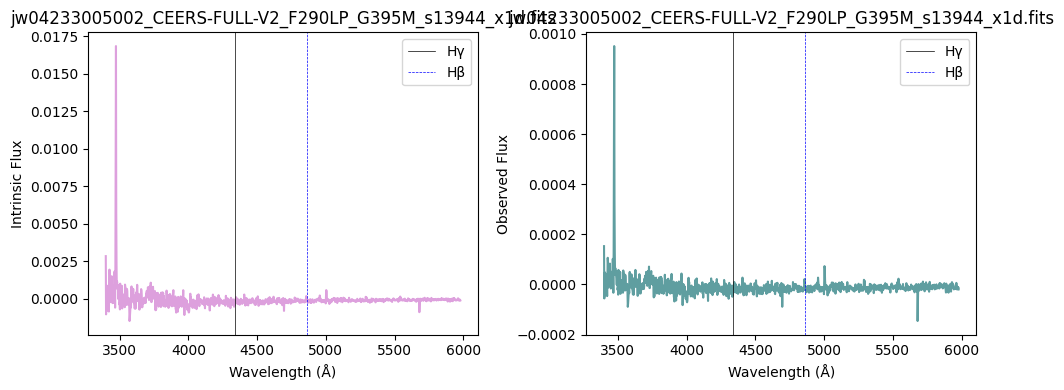

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.32237628699528936
-2.643209199214057
[2.50801955 2.50669352 2.50536845 ... 1.36011134 1.35951389 1.35891685]


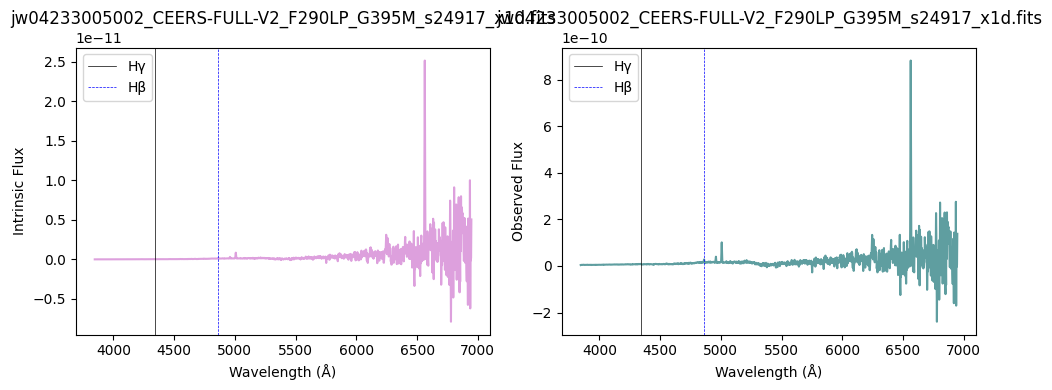

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.27539006115409
-3.011030846846549
[2.64997022 2.64862903 2.64728878 ... 1.48115474 1.48051327 1.47987224]


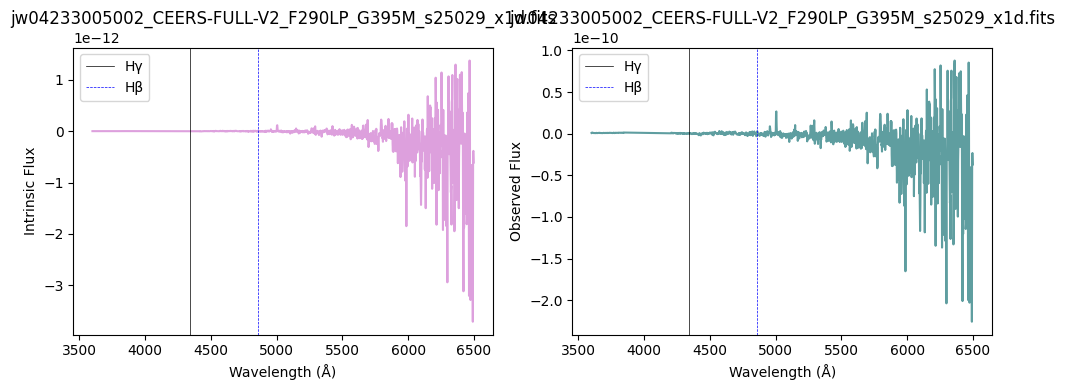

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.4971990156305169
-1.631557741176061
[2.44951789 2.44819271 2.44686851 ... 1.31276508 1.31217726 1.31158986]


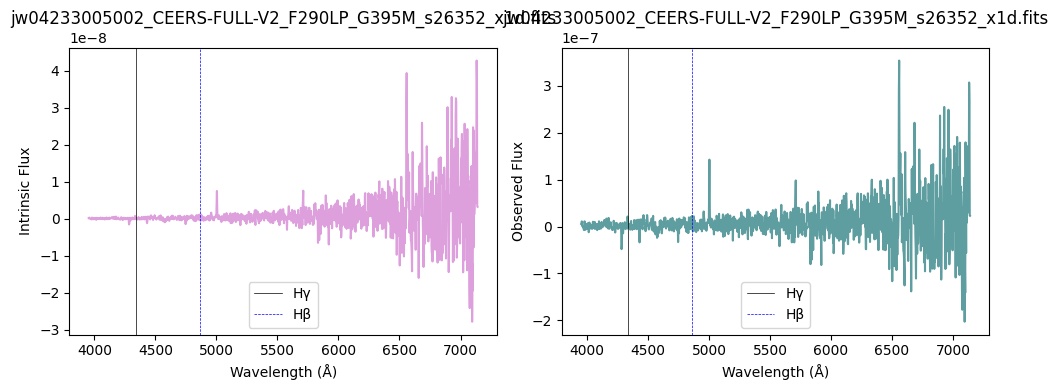

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.126476638983707
0.2780762887034907
[3.16830426 3.16693011 3.16558253 ... 1.9204764  1.91979565 1.91911523]


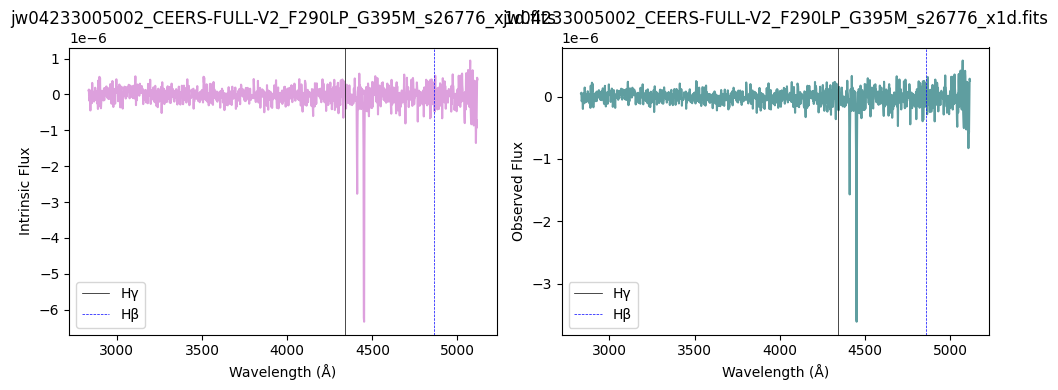

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7843487473023375
-0.5671547996437212
[2.63171647 2.63037005 2.62902458 ... 1.46699351 1.46635036 1.46570766]


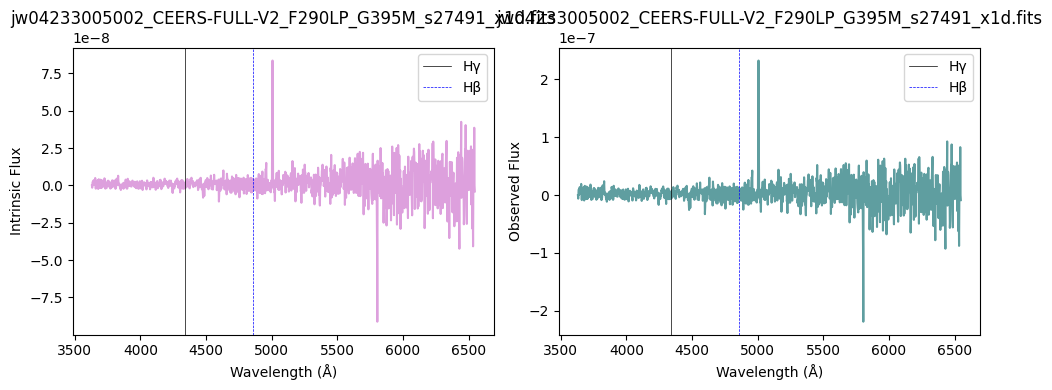

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.999328214664372
-0.0015690898160134862
[2.67754446 2.67620015 2.67485677 ... 1.50445092 1.50380027 1.50315006]


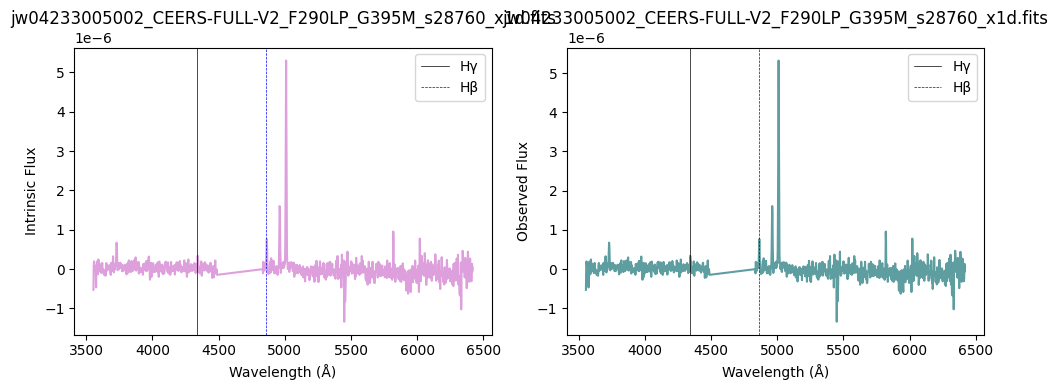

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8898735822780287
-0.2724284191416344
[2.77786858 2.77651314 2.7751586  ... 1.57801502 1.57738854 1.5767624 ]


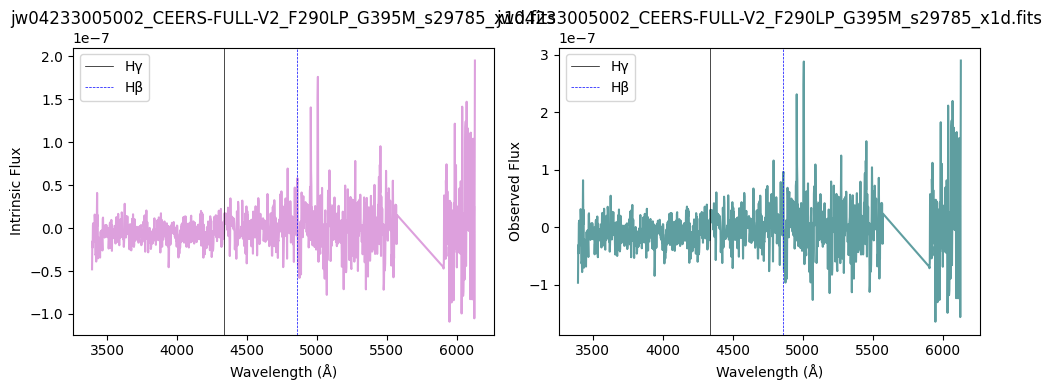

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.353690112272719
0.7070927780513259
[2.41679659 2.41547679 2.41415797 ... 1.28759741 1.28701806 1.28643911]


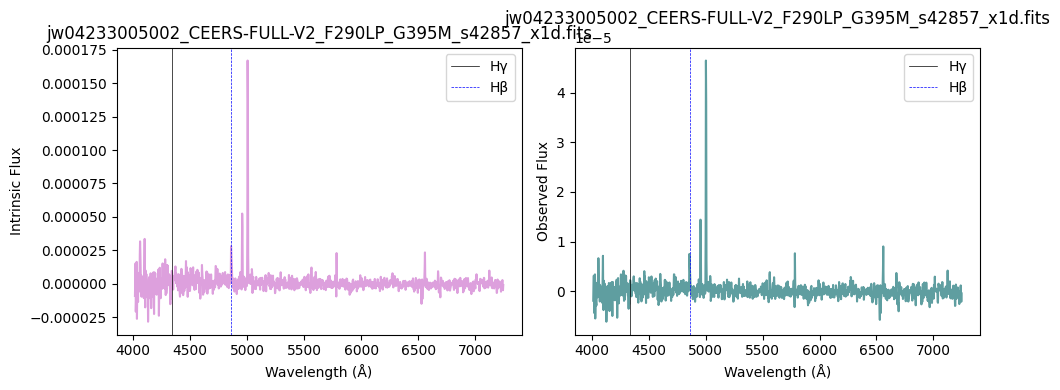

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.00985537487135
0.02289882427205117
[2.41834707 2.41702837 2.41571067 ... 1.28794688 1.28737302 1.28679956]


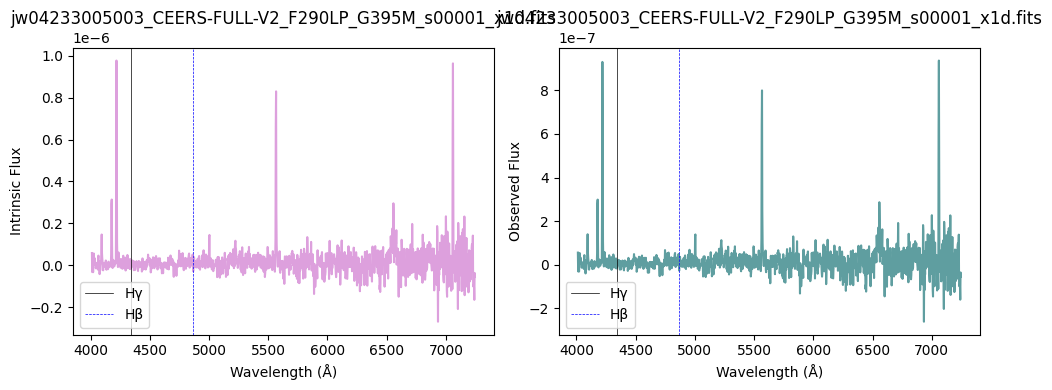

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.68664922251429
-0.8777691793196
[2.59677511 2.59543306 2.59409196 ... 1.43398557 1.43335793 1.43273071]


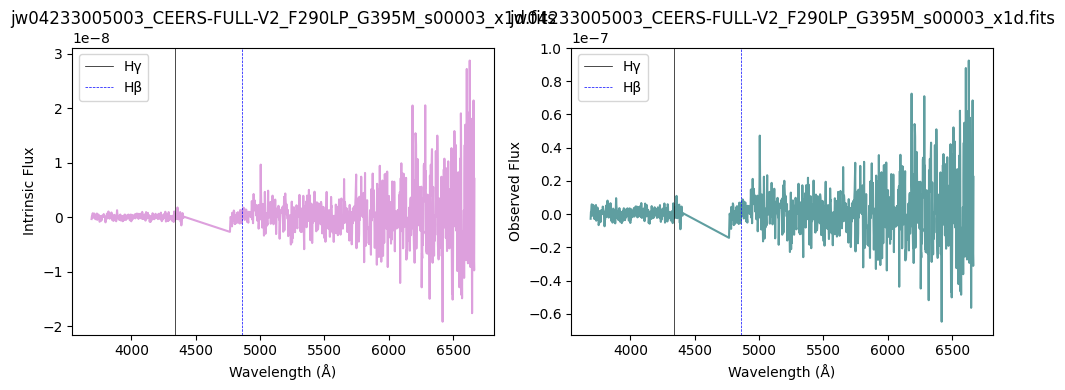

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.5027722234174674
-1.6055307727216
[2.88541347 2.88406282 2.88271303 ... 1.67024149 1.66960586 1.66897055]


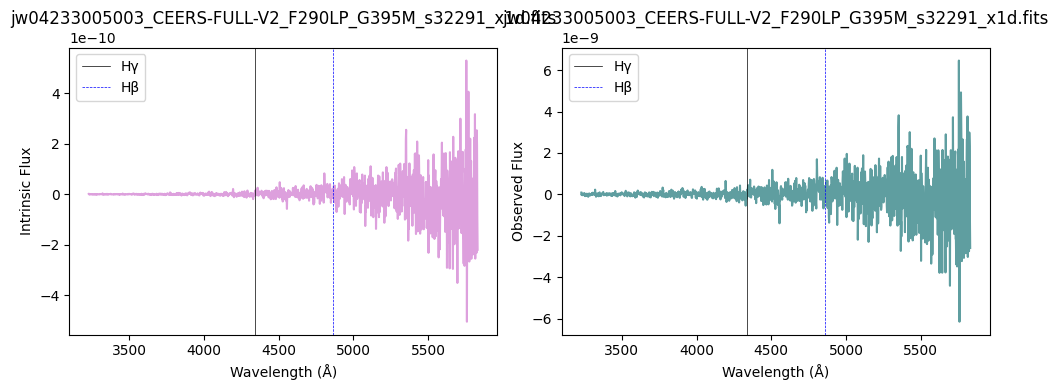

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9477882205944943
-0.12520802768486644
[2.79187869 2.79052606 2.78917432 ... 1.59048071 1.58985341 1.58922643]


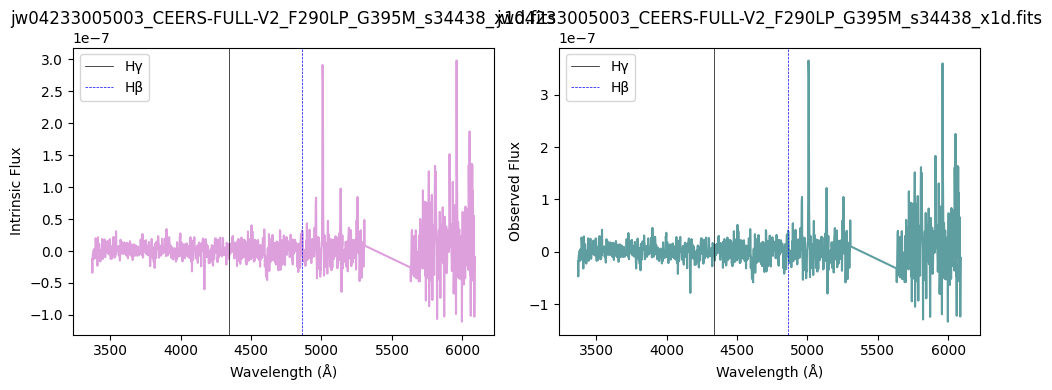

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.107527659402649
0.2384654898044866
[2.70281966 2.70146908 2.70011942 ... 1.52728705 1.52662363 1.52596067]


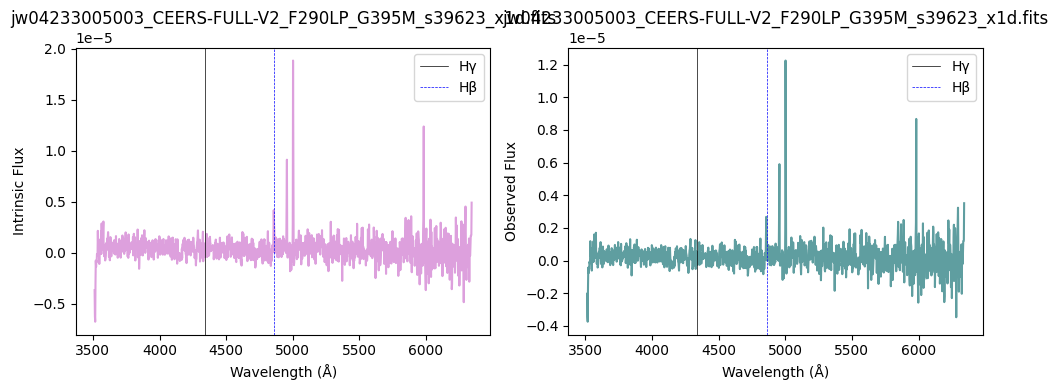

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2954837417706748
0.6044729408119109
[2.5469776  2.54564095 2.54430527 ... 1.39321542 1.39260018 1.39198537]


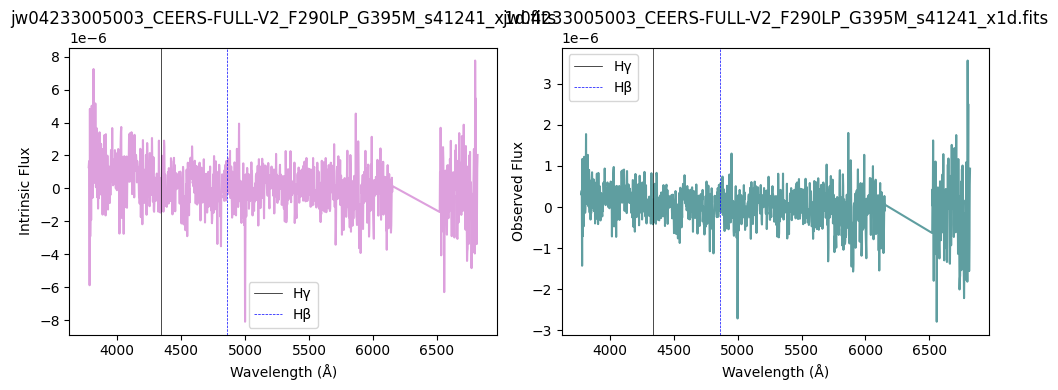

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


3.658240380566061
3.028345372485998
[2.56223969 2.56090181 2.55956489 ... 1.40597712 1.40535989 1.40474309]


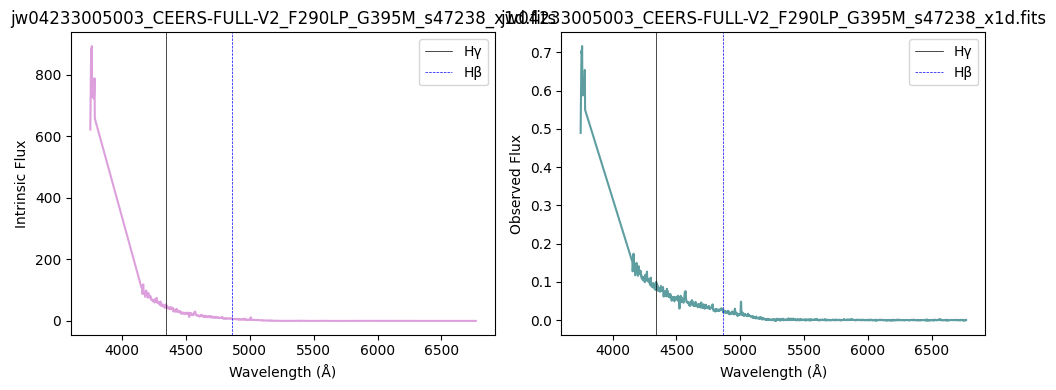

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.5285418284710806
-1.488820630116677
[2.57679204 2.57544937 2.57410766 ... 1.41871079 1.41808404 1.41745773]


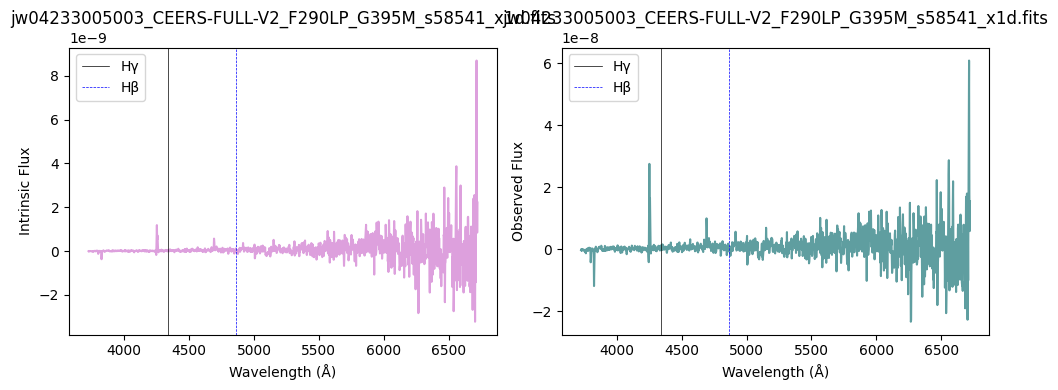

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.4340105788743611
-1.9489230352906681
[2.37882213 2.37751253 2.37620393 ... 1.25793376 1.25737143 1.2568095 ]


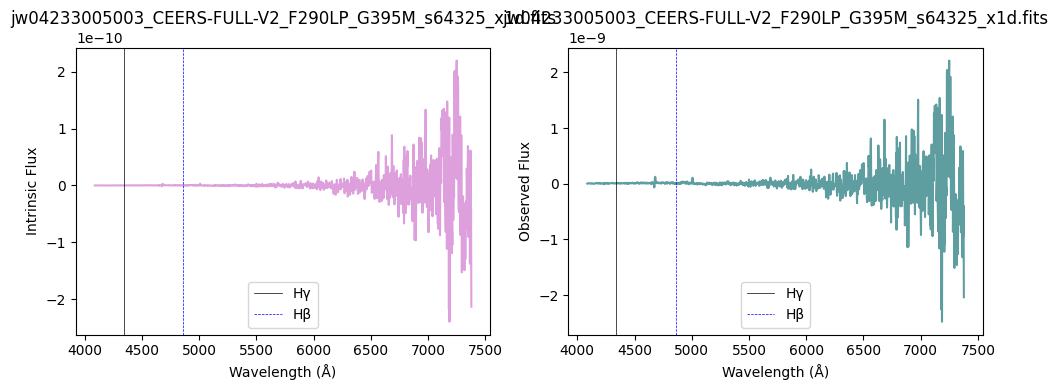

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.8517137290676833
-0.37476533416853897
[2.72140842 2.72006172 2.71868504 ... 1.53309985 1.53248214 1.53186476]


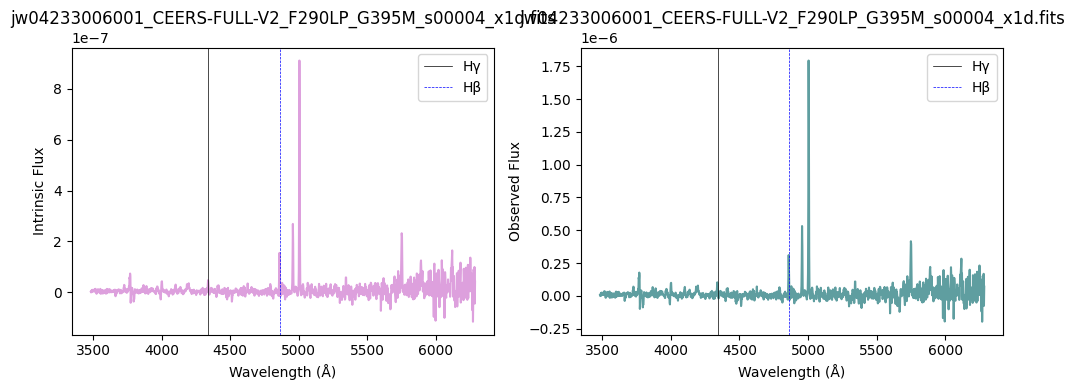

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1654775427956512
0.35754790139434794
[2.38599551 2.38468194 2.38336937 ... 1.26386671 1.26329773 1.26272914]


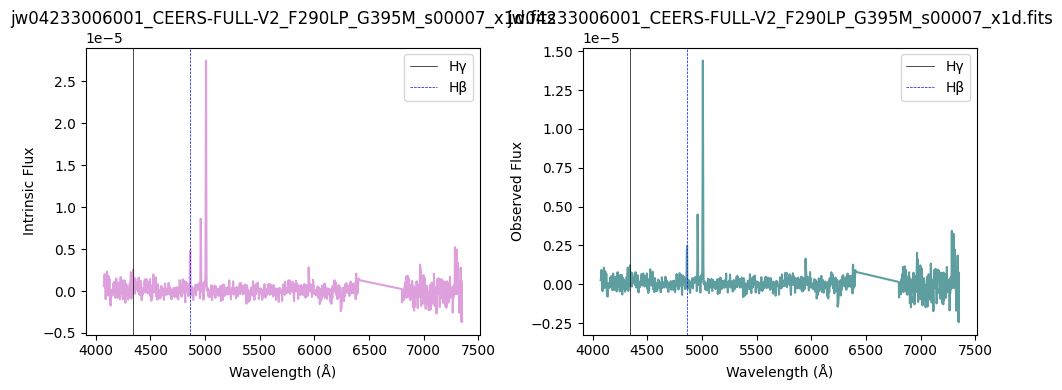

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6480745446476961
-1.0127690140772476
[2.64554064 2.64419956 2.64285941 ... 1.4774193  1.47677511 1.47613136]


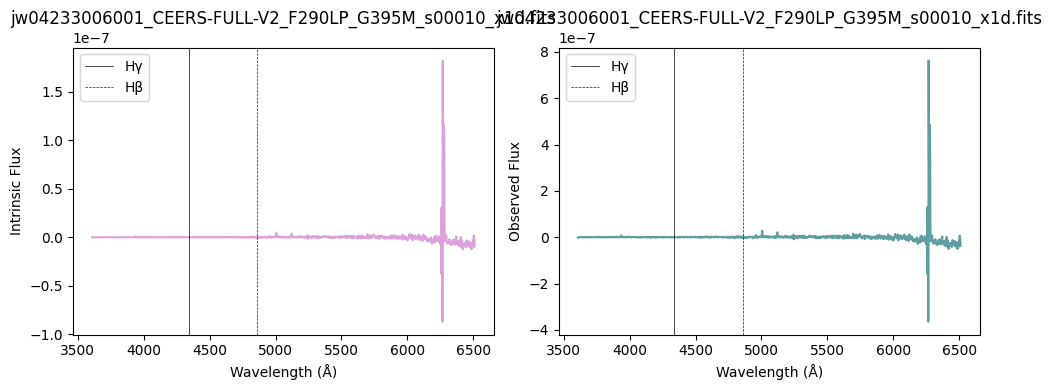

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.771004171225564
-0.607221894393312
[2.57582892 2.57449209 2.57315622 ... 1.41774388 1.41712296 1.41650246]


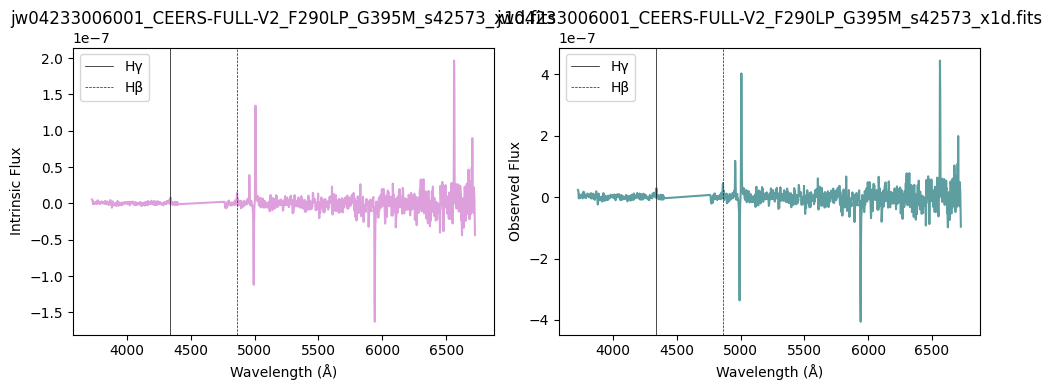

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.768237340008344
-0.6156160638132631
[2.63693391 2.6355893  2.63424562 ... 1.46973247 1.46909287 1.46845372]


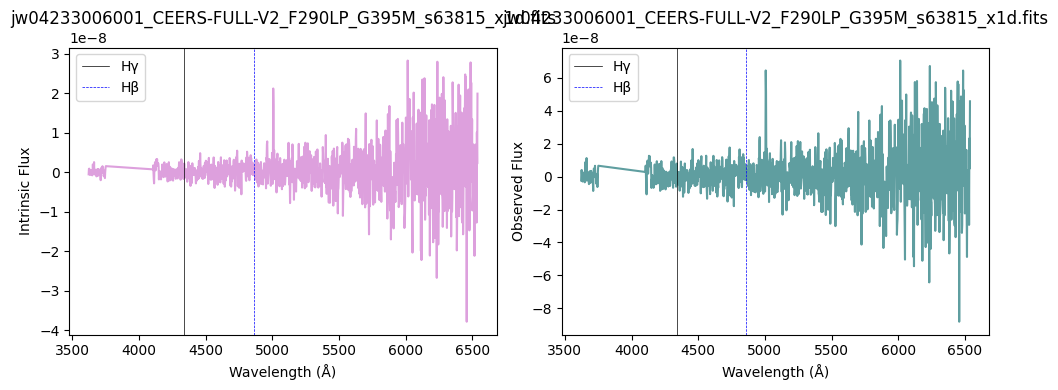

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6462300417820703
-1.0194239595419805
[2.54632353 2.5449868  2.54365103 ... 1.39334242 1.39272861 1.39211522]


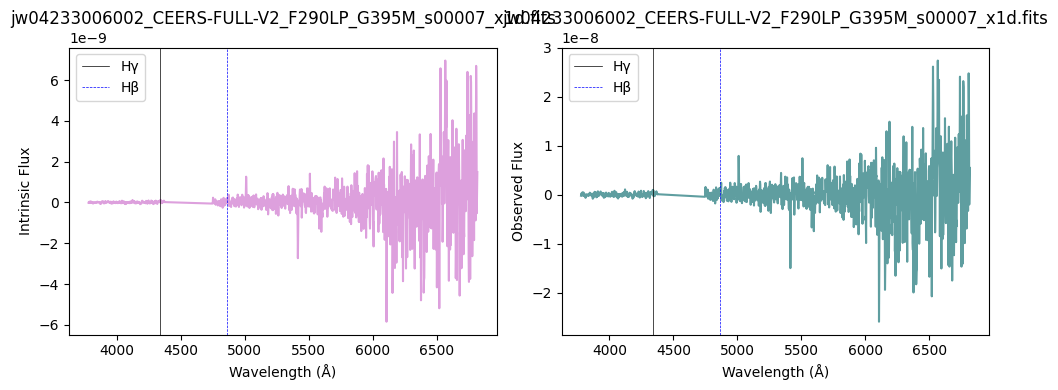

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6063632301975311
-1.1681029147807627
[2.65847888 2.65712795 2.65577796 ... 1.48752485 1.48687453 1.48622466]


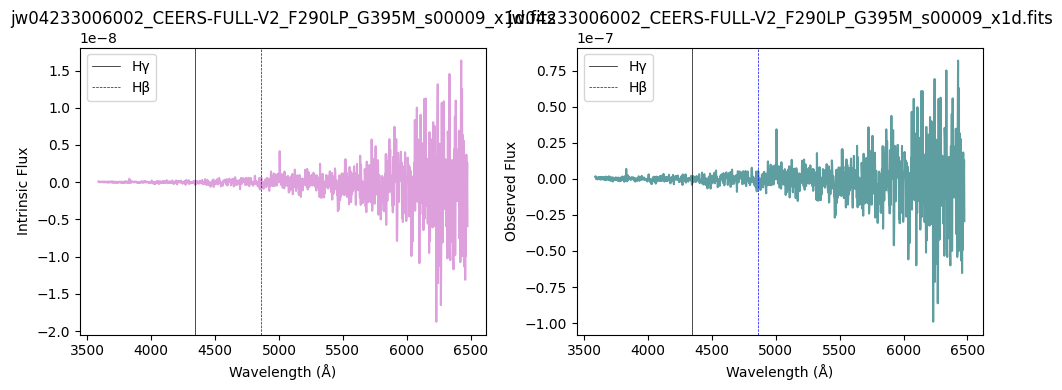

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.4687291388286616
0.8975360813718921
[2.75108774 2.74974115 2.74839546 ... 1.5573143  1.55669401 1.55607404]


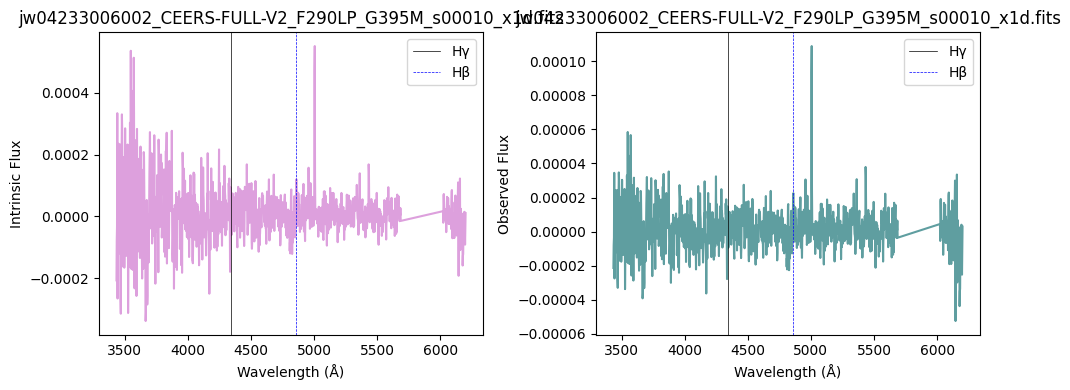

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.1563477508262212
0.33918526879443067
[2.63823577 2.63688725 2.63553967 ... 1.47094175 1.47029696 1.46965262]


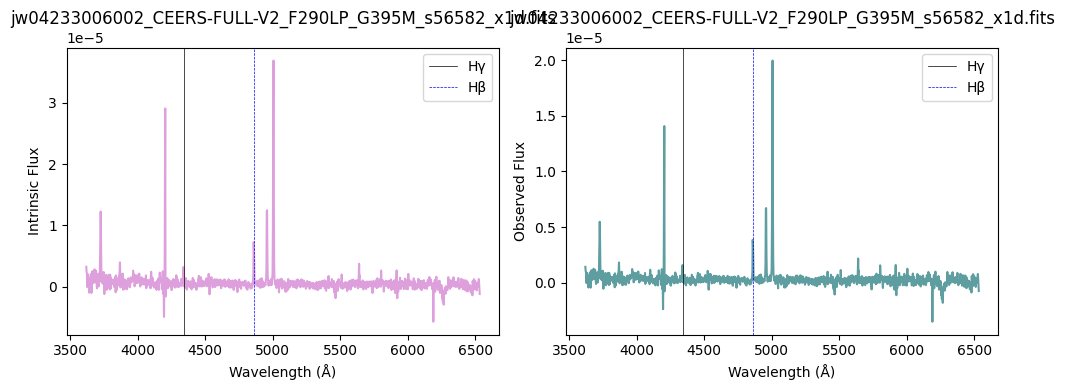

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.4048304077106412
-2.111434807099038
[2.63351608 2.63216789 2.63082065 ... 1.46573857 1.46509714 1.46445616]


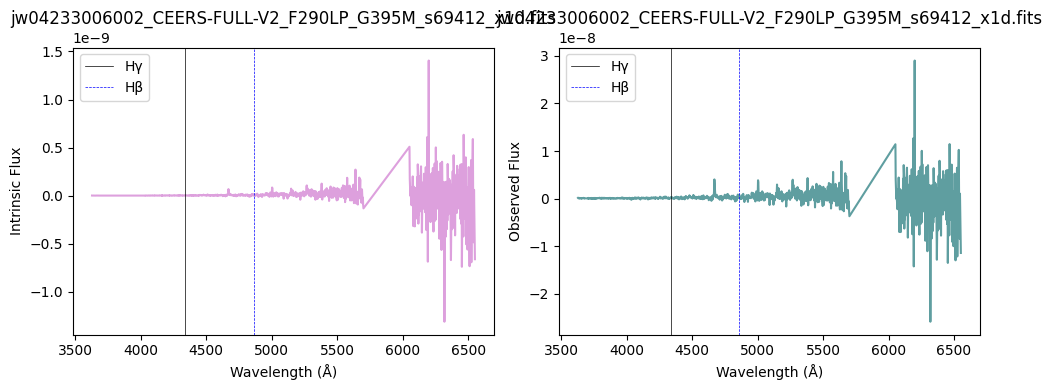

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.7671003865427269
-0.6190741850133373
[2.94310792 2.94183444 2.9405617  ... 1.82849129 1.82783135 1.82717173]


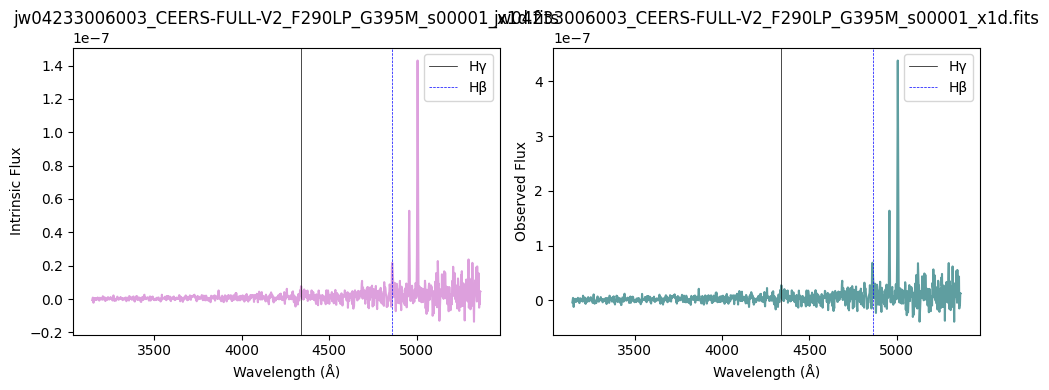

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6905039569920489
-0.8646980017016368
[2.98934734 2.98799979 2.98665306 ... 1.76094637 1.76029691 1.75964777]


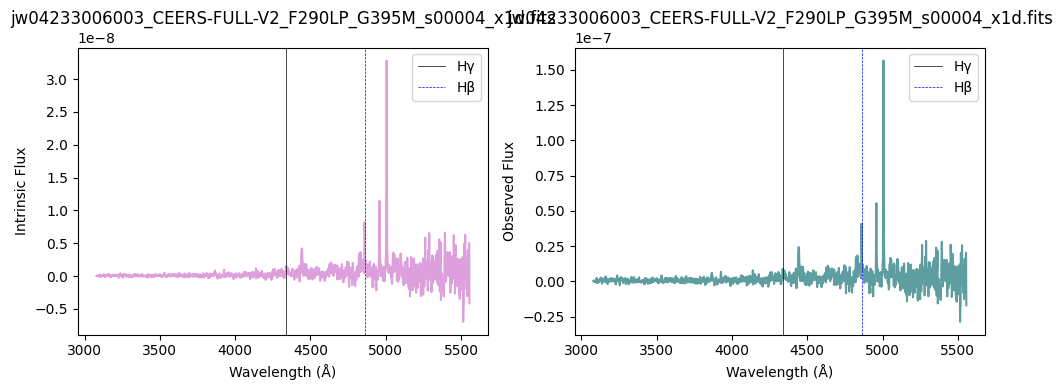

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


1.2256617718945264
0.4751109718553899
[2.36815405 2.36688756 2.36562201 ... 1.31151767 1.31093325 1.31034924]


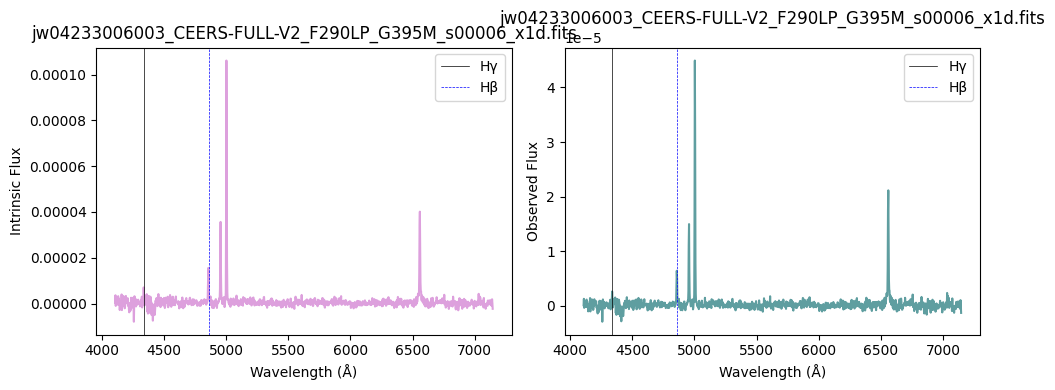

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.6460040928718903
-1.0202404862772516
[2.41838949 2.4170691  2.41574969 ... 1.28822512 1.28764733 1.28706994]


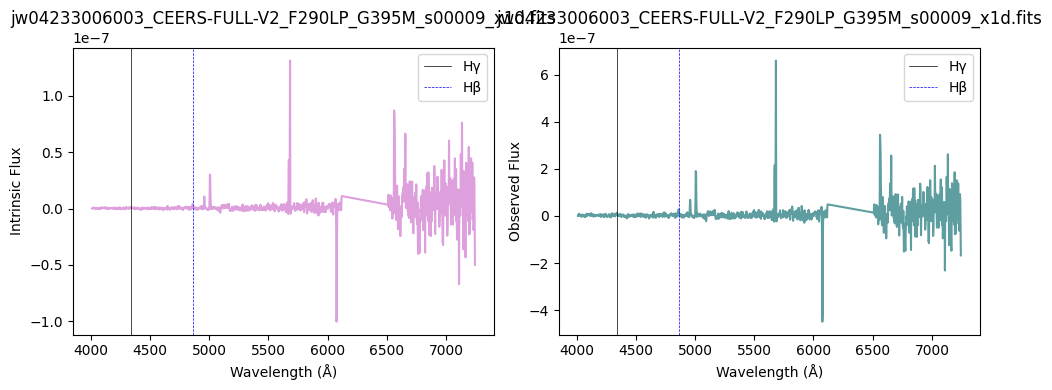

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.554314149775727
-1.3776561031652215
[2.68367938 2.68233475 2.68099105 ... 1.50956131 1.5089113  1.50826174]


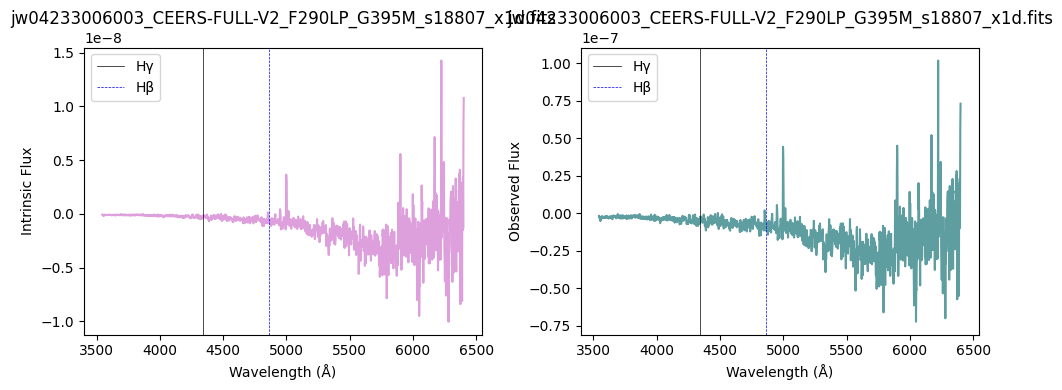

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.29002697852522424
-2.8901161388511203
[2.63213427 2.63079091 2.62942072 ... 1.46427052 1.46363207 1.46299406]


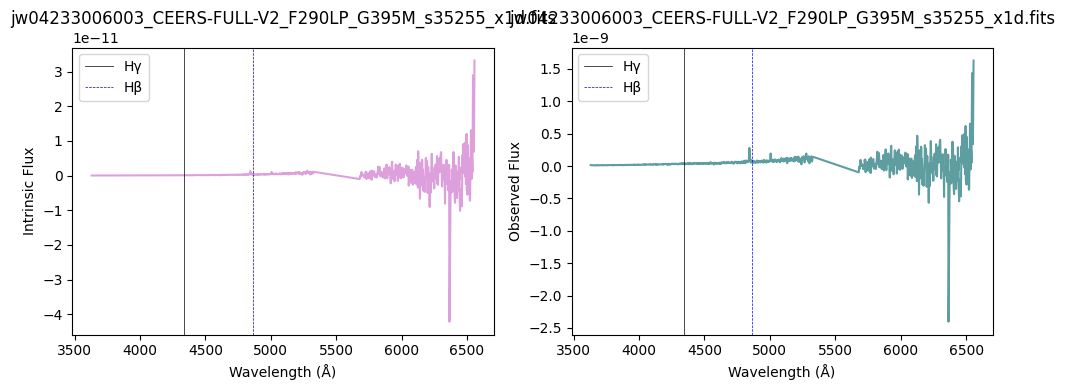

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.36307549603546385
-2.365607852859274
[2.515928   2.51459325 2.51325948 ... 1.36692777 1.36632296 1.36571857]


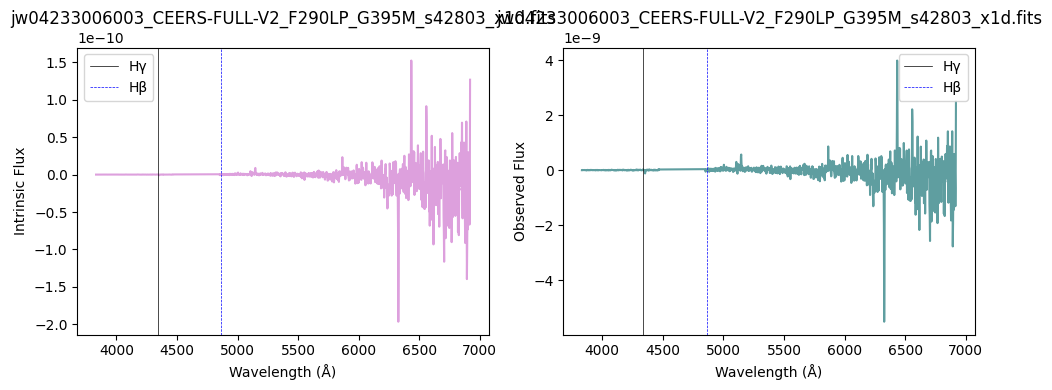

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.4651166289128856
-1.7873017916968617
[2.90865512 2.90730259 2.90595091 ... 1.68950181 1.6888621  1.68822271]


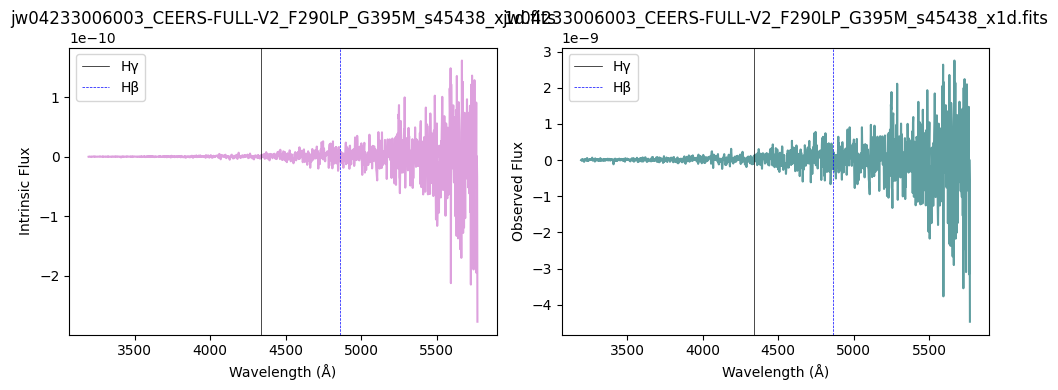

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.5400074987661544
-1.4387108029216138
[3.10805209 3.10669851 3.10534572 ... 1.86555346 1.86487978 1.86420643]


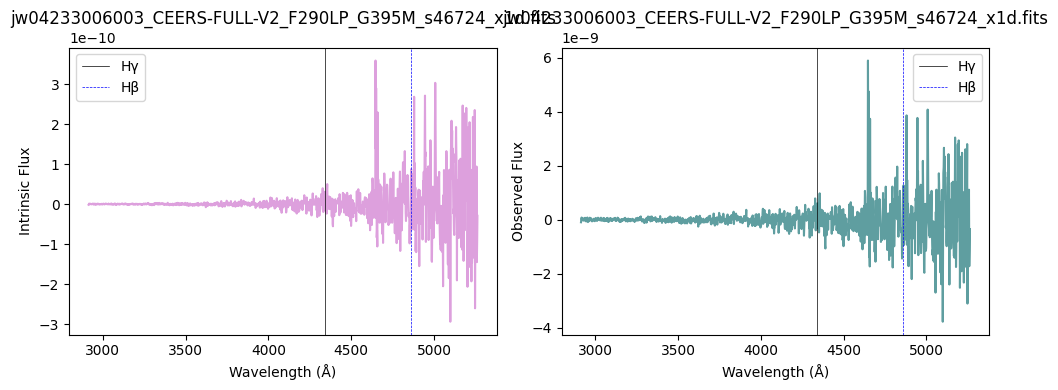

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


0.9244097602843909
-0.1835240737395943
[2.57945981 2.57811673 2.57677462 ... 1.5180779  1.51738187 1.51668635]


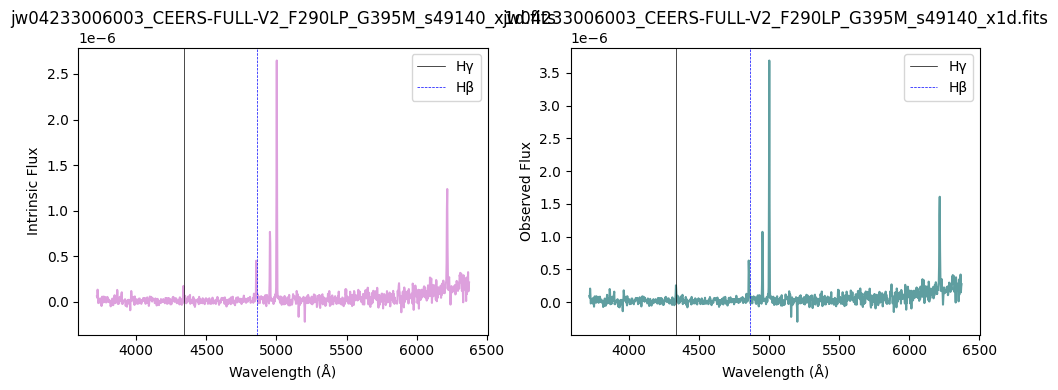

/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/opt/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


In [ ]:
%matplotlib inline

Hgamma_fluxes = []
Hbeta_fluxes = []
Halpha_fluxes= []

flux_instrinsic = []
flux_instrinsic_master = []
flux_error_master = []
flux_boolean = []
ratios = []
R_master =[]
rest_frame_wavelength = []


# Process each source
for i, r in enumerate(redshift):
    if flags[i] == True:
        file_name = source_name[i]
        after_wavelength = rest_frame[i]
        before_flux = flux[i]
        before_flux_error = flux_error[i]

    
        mask = ((np.isfinite(before_flux) )) & ((np.isfinite(before_flux_error) )) 
     
        flux_cleaned = before_flux[mask]
        flux_error_cleaned = before_flux_error[mask]
        equation_cleaned = (after_wavelength[mask])*um_to_ang

        if r<6:
            if (((np.amax(equation_cleaned)) >= h_alpha) & wavelength_exists(equation_cleaned, h_alpha) & wavelength_exists(equation_cleaned, h_beta))  :


#             plt.figure()
#             plt.plot(equation_cleaned,flux_cleaned)
#             plt.axvline(h_alpha, c= 'red', label = 'halpha',linewidth=.5,alpha=.5)
#             plt.axvline(h_beta, c='blue', label = 'hbeta',linewidth=.5,ls='--')

#             plt.title(file_name)
#             plt.show()


        #----
    
                window_wavelength = 15   
        
                #Halpha_fit = emcee_fit(equation_cleaned, flux_cleaned, flux_error_cleaned, h_alpha, window_wavelength,diagnose= False,save=False)
                Hbeta_fit = emcee_fit(equation_cleaned, flux_cleaned, flux_error_cleaned, h_beta, window_wavelength,diagnose= False,save=False)
                Halpha_fit = emcee_fit(equation_cleaned, flux_cleaned, flux_error_cleaned, h_alpha, window_wavelength,diagnose= False,save=False)
        
                #reddening 
                R = (Hbeta_fit/Hgamma_fit) /1.163
                ratio = ((Hbeta_fit/Hgamma_fit))
                #E(B-V)
                # if R<3:
                #     R_master.append('Yes')
                # if R>3:
                #     R_master.append('No')
                EBV = (np.log10(R) / (0.4* 2.87))
                #piecewise k function
                k = np.piecewise(equation_cleaned/ um_to_ang,
                    [np.logical_and(equation_cleaned / um_to_ang >= (0.63), equation_cleaned / um_to_ang <= (2.20 )),
                     np.logical_and(equation_cleaned / um_to_ang >= (0.12 ), equation_cleaned / um_to_ang <= (0.63))],
                    [lambda x: 1.17 * (-1.857 + (1.040 / x)) + 1.78,
                     lambda x: 1.17 * ((-2.156 + (1.509 / x)) - (0.198 / (x**2)) + (0.011 / (x**3)) )+ 1.78])
                print(R)
                print(EBV)
                #calculate flux array
                f_instrinsic = flux_cleaned*(10**(0.4*EBV*k))
                print(k)
                flux_error_corrected = flux_error_cleaned*(10**(0.4*EBV*k)) 
##calzetti 2001 takes only wavelengths in um (microns) NOT angstorms
##also make sure to divide every wavelength by required unit conversion to get A -> microns
                before_flux[mask] = f_instrinsic
                before_flux_error[mask] = flux_error_corrected
        
                flux_instrinsic_master.append(before_flux.astype(float))
                flux_error_master.append(before_flux_error.astype(float))
                flux_boolean.append('Yes')
        
                Halpha_fluxes.append(Halpha_fit)  
                Hbeta_fluxes.append(Hbeta_fit)
        
                ratios.append(ratio)
        
                # Create a figure with 2 subplots (1 row, 2 columns)
                fig, axes = plt.subplots(1, 2,figsize=(10,4))
        
                # Plot f_instrinsic on the left subplot
                axes[0].plot(equation_cleaned, f_instrinsic, color='plum')
                axes[0].axvline(h_alpha, c='k', label='Hα', linewidth=0.5)
                axes[0].axvline(h_beta, c='blue', label='Hβ', linewidth=0.5, ls='--')
                axes[0].set_title(f"{file_name}")
                axes[0].set_xlabel('Wavelength (Å)')
                axes[0].set_ylabel('Intrinsic Flux')
                axes[0].legend()
        
                # Plot flux_cleaned on the right subplot
                axes[1].plot(equation_cleaned, flux_cleaned, color='cadetblue')
                axes[1].axvline(h_alpha, c='k', label='Hα', linewidth=0.5)
                axes[1].axvline(h_beta, c='blue', label='Hβ', linewidth=0.5, ls='--')
                axes[1].set_title(f"{file_name}")
                axes[1].set_xlabel('Wavelength (Å)')
                axes[1].set_ylabel('Observed Flux')
                axes[1].legend()
        
                # Display the plots
                plt.tight_layout()
                plt.show()
        
            else:
                flux_instrinsic_master.append(before_flux.astype(float))
                flux_boolean.append('No')
                #flux_instrinsic_master.append(np.ones(len(flux))*np.nan)
                flux_error_master.append(before_flux_error.astype(float))
                ratios.append(0)

        elif r >6:
            if (((np.amax(equation_cleaned)) >= h_beta) & wavelength_exists(equation_cleaned, h_gamma) & wavelength_exists(equation_cleaned, h_beta))  :


#             plt.figure()
#             plt.plot(equation_cleaned,flux_cleaned)
#             plt.axvline(h_alpha, c= 'red', label = 'halpha',linewidth=.5,alpha=.5)
#             plt.axvline(h_beta, c='blue', label = 'hbeta',linewidth=.5,ls='--')

#             plt.title(file_name)
#             plt.show()


        #----
    
                window_wavelength = 15   
        
                #Halpha_fit = emcee_fit(equation_cleaned, flux_cleaned, flux_error_cleaned, h_alpha, window_wavelength,diagnose= False,save=False)
                Hbeta_fit = emcee_fit(equation_cleaned, flux_cleaned, flux_error_cleaned, h_beta, window_wavelength,diagnose= False,save=False)
                Hgamma_fit = emcee_fit(equation_cleaned, flux_cleaned, flux_error_cleaned, h_gamma, window_wavelength,diagnose= False,save=False)
        
                #reddening 
                R = (Hbeta_fit/Hgamma_fit) / 2.12765957447
                ratio = ((Hbeta_fit/Hgamma_fit))
                #E(B-V)
                # if R<3:
                #     R_master.append('Yes')
                # if R>3:
                #     R_master.append('No')
                EBV = (np.log10(R) / (0.4*0.465))
                #piecewise k function
                k = np.piecewise(equation_cleaned/ um_to_ang,
                    [np.logical_and(equation_cleaned / um_to_ang >= (0.63), equation_cleaned / um_to_ang <= (2.20 )),
                     np.logical_and(equation_cleaned / um_to_ang >= (0.12 ), equation_cleaned / um_to_ang <= (0.63))],
                    [lambda x: 1.17 * (-1.857 + (1.040 / x)) + 1.78,
                     lambda x: 1.17 * ((-2.156 + (1.509 / x)) - (0.198 / (x**2)) + (0.011 / (x**3)) )+ 1.78])
                print(R)
                print(EBV)
                #calculate flux array
                f_instrinsic = flux_cleaned*(10**(0.4*EBV*k))
                print(k)
                flux_error_corrected = flux_error_cleaned*(10**(0.4*EBV*k)) 
##calzetti 2001 takes only wavelengths in um (microns) NOT angstorms
##also make sure to divide every wavelength by required unit conversion to get A -> microns
                before_flux[mask] = f_instrinsic
                before_flux_error[mask] = flux_error_corrected
        
                flux_instrinsic_master.append(before_flux.astype(float))
                flux_error_master.append(before_flux_error.astype(float))
                flux_boolean.append('Yes')
        
                #Halpha_fluxes.append(Halpha_fit)  # A from the fit is the flux
                Hgamma_fluxes.append(Hgamma_fit)
                Hbeta_fluxes.append(Hbeta_fit)
        
                ratios.append(ratio)
        
                # Create a figure with 2 subplots (1 row, 2 columns)
                fig, axes = plt.subplots(1, 2,figsize=(10,4))
        
                # Plot f_instrinsic on the left subplot
                axes[0].plot(equation_cleaned, f_instrinsic, color='plum')
                axes[0].axvline(h_gamma, c='k', label='Hγ', linewidth=0.5)
                axes[0].axvline(h_beta, c='blue', label='Hβ', linewidth=0.5, ls='--')
                axes[0].set_title(f"{file_name}")
                axes[0].set_xlabel('Wavelength (Å)')
                axes[0].set_ylabel('Intrinsic Flux')
                axes[0].legend()
        
                # Plot flux_cleaned on the right subplot
                axes[1].plot(equation_cleaned, flux_cleaned, color='cadetblue')
                axes[1].axvline(h_gamma, c='k', label='Hγ', linewidth=0.5)
                axes[1].axvline(h_beta, c='blue', label='Hβ', linewidth=0.5, ls='--')
                axes[1].set_title(f"{file_name}")
                axes[1].set_xlabel('Wavelength (Å)')
                axes[1].set_ylabel('Observed Flux')
                axes[1].legend()
        
                # Display the plots
                plt.tight_layout()
                plt.show()
        
            else:
                flux_instrinsic_master.append(before_flux.astype(float))
                flux_boolean.append('No')
                #flux_instrinsic_master.append(np.ones(len(flux))*np.nan)
                flux_error_master.append(before_flux_error.astype(float))
                ratios.append(0)


In [ ]:
RUBIES_and_CEERS_table['flux_intrinsic'] = flux_instrinsic_master
RUBIES_and_CEERS_table['flux_error_corrected']= flux_error_master
RUBIES_and_CEERS_table['dust_corrected']= flux_boolean
RUBIES_and_CEERS_table['Hbeta/Hgamma']= ratios
#RUBIES_table['R VALUES']= R_master
RUBIES_and_CEERS_table.write('MASTER_RUBIES_AND_CEERS_TABLE.fits',overwrite=True)

In [ ]:
RUBIES_and_CEERS_table